# Building makemore - Activations & Gradients, BatchNorm

## Imports

In [ ]:
#!pip install tqdm

In [ ]:
from tqdm import tqdm, tqdm_notebook
import numpy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plot
import random
import math

In [ ]:
g = torch.Generator().manual_seed(42)

## Setup

In [ ]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [ ]:
len(words)

32033

In [ ]:
def generate_training_set(words, block_size, print_disabled=False):
    
    chars = sorted(list(set(''.join(words))))
    stoi = {s: i+1 for i, s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s, i in stoi.items()}
    
    X, Y = [], []
    
    for w in words:
        if print_disabled: print(w)
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if print_disabled: print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [ ]:
X, Y = generate_training_set(words, 3)

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
def generate_train_valid_test_split(words, block_size=3):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*len(words))
    n2 = int(0.9*len(words))

    Xtr, Ytr = generate_training_set(words[:n1], block_size)
    Xdev, Ydev = generate_training_set(words[n1:n2], block_size)
    Xte, Yte = generate_training_set(words[n2:], block_size)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [ ]:
Xtr, Ytr, Xdev, Ydev, Xte, Yte = generate_train_valid_test_split(words, block_size=3)

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
Xdev.shape, Ydev.shape

(torch.Size([22655, 3]), torch.Size([22655]))

In [ ]:
Xte.shape, Yte.shape

(torch.Size([22866, 3]), torch.Size([22866]))

## Train

In [ ]:
def compute_logits(parameters, X):
    C, W1, b1, W2, b2 = parameters
    emb = C[X]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
    return h @ W2 + b2

In [ ]:
def _regularization_loss(parameters, lambdas):
    return sum(l * (p**2).mean() for p, l in zip(parameters, lambdas))

In [ ]:
def initilialize_parameters(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g)
    b1 = torch.randn(hidden_neuron, generator=g)
    W2 = torch.randn((hidden_neuron, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    return [C, W1, b1, W2, b2]

In [ ]:
def train(parameters,
          epochs,
          X, 
          Y, 
          bs=32, 
          lambdas = [0, 0, 0],
          enable_print=True,
          print_at_every_nth_epoch=10000
         ):
    
    if not parameters:
        raise Exception("No initial parameters passed")
    
    for p in parameters: p.requires_grad = True 
    
    losses = []
    for epoch in tqdm(range(epochs)):
        
        lr = 0.1 if epoch < 100_000 else 0.01
        
        ix = torch.randint(0, X.shape[0], (bs, ))
        batch_x, batch_y = X[ix], Y[ix]
        logits = compute_logits(parameters, batch_x)
        loss = F.cross_entropy(logits, batch_y)
        regularization_loss = _regularization_loss(parameters, lambdas)
        loss += regularization_loss

        for p in parameters:
            p.grad= None
        loss.backward()


        for p in parameters:
            p.data += - lr * p.grad

        if enable_print and epoch % print_at_every_nth_epoch == 0: print(epoch, loss.item())
            
        losses.append(loss.item())
        
    if enable_print:  print(epoch, loss.item())   
    return losses

In [ ]:
params1 = initilialize_parameters(3, 10, 200)

In [ ]:
losses = train(params1, 200_000, Xtr, Ytr)

  0%|                                                                                                                                                                  | 50/200000 [00:00<14:51, 224.22it/s]

0 27.642881393432617


  5%|████████                                                                                                                                                       | 10086/200000 [00:16<05:14, 602.91it/s]

10000 2.6563515663146973


 10%|███████████████▉                                                                                                                                               | 19993/200000 [00:36<06:22, 470.09it/s]

20000 2.4569218158721924


 15%|███████████████████████▉                                                                                                                                       | 30086/200000 [00:56<05:16, 536.84it/s]

30000 2.4299867153167725


 20%|███████████████████████████████▉                                                                                                                               | 40107/200000 [01:15<04:28, 595.70it/s]

40000 2.2356979846954346


 25%|███████████████████████████████████████▊                                                                                                                       | 50117/200000 [01:34<04:09, 601.27it/s]

50000 2.222148895263672


 30%|███████████████████████████████████████████████▊                                                                                                               | 60073/200000 [01:50<03:55, 593.51it/s]

60000 1.997029423713684


 35%|███████████████████████████████████████████████████████▋                                                                                                       | 70114/200000 [02:08<03:43, 581.43it/s]

70000 2.013292074203491


 40%|███████████████████████████████████████████████████████████████▋                                                                                               | 80089/200000 [02:26<03:26, 579.70it/s]

80000 2.4996888637542725


 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 90115/200000 [02:43<03:00, 607.76it/s]

90000 2.8243627548217773


 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 100092/200000 [03:00<02:46, 598.58it/s]

100000 2.815431833267212


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 110109/200000 [03:16<02:30, 599.05it/s]

110000 2.333662509918213


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 120106/200000 [03:33<02:08, 619.76it/s]

120000 2.5455234050750732


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 130061/200000 [03:53<04:29, 259.66it/s]

130000 2.3017194271087646


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 140117/200000 [04:14<01:39, 600.35it/s]

140000 2.1503050327301025


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 150090/200000 [04:30<01:20, 620.44it/s]

150000 1.8232505321502686


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 160095/200000 [04:47<01:02, 639.88it/s]

160000 2.411186456680298


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 170112/200000 [05:02<00:46, 637.91it/s]

170000 2.52275013923645


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 180125/200000 [05:18<00:31, 634.12it/s]

180000 2.173576593399048


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 190104/200000 [05:34<00:15, 644.02it/s]

190000 2.165059804916382


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [05:50<00:00, 571.05it/s]

199999 2.3922524452209473


[<matplotlib.lines.Line2D>]

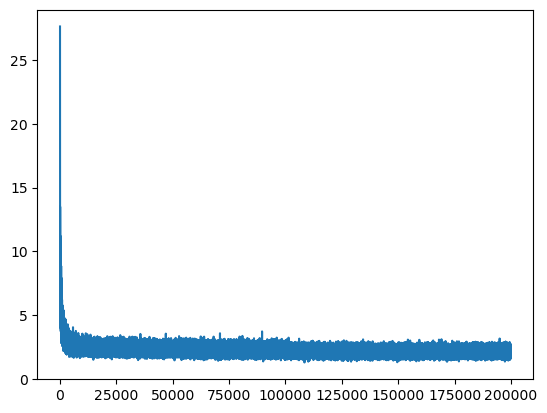

In [ ]:
plot.plot(losses)

## Evaluate Loss

In [ ]:
#torch.no_grad()
def evaluate_loss(parameters, X, Y):
    logits = compute_logits(parameters, X)
    return F.cross_entropy(logits, Y)

In [ ]:
def loss_split(parameters, dataset='train'):
    dataset_choices = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte)
    }
    return evaluate_loss(parameters, *dataset_choices[dataset])

In [ ]:
loss_split(params1), loss_split(params1, 'valid')

(tensor(2.1137, grad_fn=<NllLossBackward0>),
 tensor(2.1547, grad_fn=<NllLossBackward0>))

## Sampling

In [ ]:
def generate_words(parameters, count, block_size=3):
    for _ in range(count):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            logits = compute_logits(parameters, torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0: break

        print(''.join(itos[i] for i in out))

In [ ]:
generate_words(params1, 10)

jacklyny.
nita.
sano.
maketissariydah.
jama.
coanley.
zemyni.
khreen.
sis.
cin.


## Fixing the initial loss

In the above training, at the 1st epoch the loss is 33.7 then it drops to 2.23

if all the probabilities are uniform then we will expect a loss of 

In [ ]:
- torch.tensor(1/27.0).log()

tensor(3.2958)

### Sample issue

In [ ]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [ ]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [ ]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [ ]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0808, 0.5283, 0.2293, 0.1616]), tensor(1.4727))

In [ ]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([1.8579e-01, 8.1123e-01, 1.6882e-04, 2.8133e-03]), tensor(8.6867))

In [ ]:
logits = torch.rand(4) 
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.3815, 0.2294, 0.2123, 0.1768]), tensor(1.5497))

In [ ]:
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [ ]:
params2 = initilialize_parameters(3, 10, 200)

In [ ]:
losses = train(params2, 1, Xtr, Ytr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 357.51it/s]

0 28.708385467529297
0 28.708385467529297


In [ ]:
compute_logits(params2, Xtr)[0] # the logits are not uniform

tensor([  9.6100,   0.7546,  -4.9247,  -7.5269, -27.5197,  -7.1780,  -9.5191,
         -6.9432, -11.4050,  15.3572,   3.7384,  24.8570,   5.2003,  -9.1091,
          8.3202,   2.2977,  13.8022,   8.5462, -10.4909,  15.6155,  10.7404,
        -10.5370,   4.4306,  22.4479,  21.0907,  13.4340,   5.8010],
       grad_fn=<SelectBackward0>)

In [ ]:
def initilialize_parameters_v2(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g)
    b1 = torch.randn(hidden_neuron, generator=g)
    W2 = torch.randn((hidden_neuron, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
    return [C, W1, b1, W2, b2]

In [ ]:
params3 = initilialize_parameters_v2(3, 10, 200)

In [ ]:
losses = train(params3, 1, Xtr, Ytr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.04it/s]

0 3.2968194484710693
0 3.2968194484710693


In [ ]:
compute_logits(params3, Xtr)[0]

tensor([-0.1350,  0.2579, -0.1748,  0.3775, -0.1732, -0.2264, -0.0493, -0.3319,
         0.0467, -0.0121, -0.0923, -0.3330, -0.0462,  0.5159,  0.3215,  0.0554,
        -0.0875, -0.2089, -0.1959,  0.1785,  0.1165, -0.2548, -0.2711, -0.1847,
        -0.3341,  0.3078, -0.2509], grad_fn=<SelectBackward0>)

The logits are closer to zero now

In [ ]:
params4 = initilialize_parameters_v2(3, 10, 200)

In [ ]:
losses = train(params4, 200_000, Xtr, Ytr)

  0%|                                                                                                                                                                  | 23/200000 [00:00<14:34, 228.75it/s]

0 3.3012616634368896


  5%|████████                                                                                                                                                       | 10114/200000 [00:18<05:16, 599.28it/s]

10000 2.0390188694000244


 10%|███████████████▉                                                                                                                                               | 20079/200000 [00:37<05:10, 579.29it/s]

20000 2.519038200378418


 15%|███████████████████████▉                                                                                                                                       | 30114/200000 [00:55<04:55, 575.28it/s]

30000 1.9892827272415161


 20%|███████████████████████████████▉                                                                                                                               | 40108/200000 [01:13<04:50, 550.33it/s]

40000 1.973912239074707


 25%|███████████████████████████████████████▊                                                                                                                       | 50088/200000 [01:30<04:06, 607.78it/s]

50000 2.0713963508605957


 30%|███████████████████████████████████████████████▊                                                                                                               | 60080/200000 [01:47<03:51, 604.43it/s]

60000 1.9657005071640015


 35%|███████████████████████████████████████████████████████▋                                                                                                       | 70121/200000 [02:03<03:34, 604.67it/s]

70000 2.3061559200286865


 40%|███████████████████████████████████████████████████████████████▋                                                                                               | 80125/200000 [02:19<03:10, 629.99it/s]

80000 1.693084478378296


 45%|███████████████████████████████████████████████████████████████████████▌                                                                                       | 90074/200000 [02:36<03:05, 591.36it/s]

90000 2.190971851348877


 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 100078/200000 [02:52<02:44, 608.54it/s]

100000 2.581700563430786


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 110082/200000 [03:08<02:24, 624.28it/s]

110000 1.8936327695846558


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 120123/200000 [03:25<02:08, 622.65it/s]

120000 2.3227176666259766


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 130079/200000 [03:42<02:21, 495.27it/s]

130000 1.8893438577651978


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 140100/200000 [03:58<01:34, 632.41it/s]

140000 2.0941903591156006


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 150100/200000 [04:15<01:24, 593.63it/s]

150000 2.1335291862487793


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 160112/200000 [04:32<01:12, 552.32it/s]

160000 2.551553964614868


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 170099/200000 [04:49<00:50, 588.99it/s]

170000 1.945476770401001


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 180120/200000 [05:05<00:32, 618.06it/s]

180000 2.069230318069458


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 190054/200000 [05:22<00:17, 554.68it/s]

190000 1.791576862335205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [05:39<00:00, 589.22it/s]


199999 2.231049060821533


In [ ]:
loss_split(params4, 'train'), loss_split(params4, 'valid')

(tensor(2.0690, grad_fn=<NllLossBackward0>),
 tensor(2.1281, grad_fn=<NllLossBackward0>))

## Fix the saturated tanh

### Plot `tanh`

In [ ]:
x = torch.linspace(-10, 10, 1000)

[<matplotlib.lines.Line2D>]

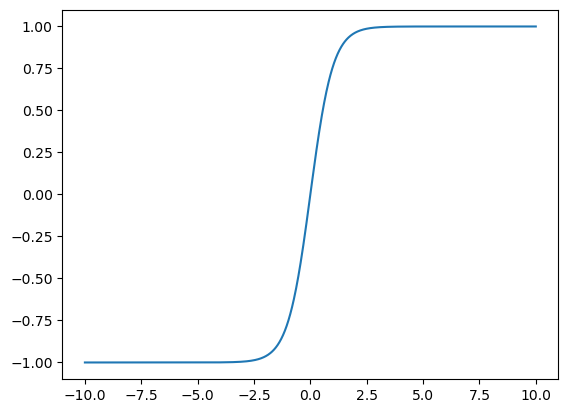

In [ ]:
plot.plot(x, torch.tanh(x))

### Visualize h
> h is the output of tanh in the above neural network

In [ ]:
def compute_h(parameters, X):
    C, W1, b1, W2, b2 = parameters
    emb = C[X]
    return torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)

In [ ]:
batch_x = Xtr[torch.randint(0, Xtr.shape[0], (32, ))]

In [ ]:
h = compute_h(params4, batch_x)

In [ ]:
h

tensor([[ 1.0000, -1.0000,  0.2621,  ..., -0.9742,  0.9999, -1.0000],
        [ 1.0000, -1.0000,  0.9999,  ...,  0.2515,  0.1090, -0.8337],
        [ 1.0000, -1.0000,  0.6779,  ..., -0.8491, -0.9900,  0.9737],
        ...,
        [ 0.9999,  0.9009, -0.9950,  ..., -1.0000,  0.9464,  0.9997],
        [ 1.0000,  1.0000, -0.9781,  ...,  0.9608,  0.9965,  0.9994],
        [-0.9998,  0.8074, -0.9989,  ...,  1.0000,  0.9892,  0.9999]],
       grad_fn=<TanhBackward0>)

In [ ]:
h.shape

torch.Size([32, 200])

In [ ]:
h.view(-1).shape

torch.Size([6400])

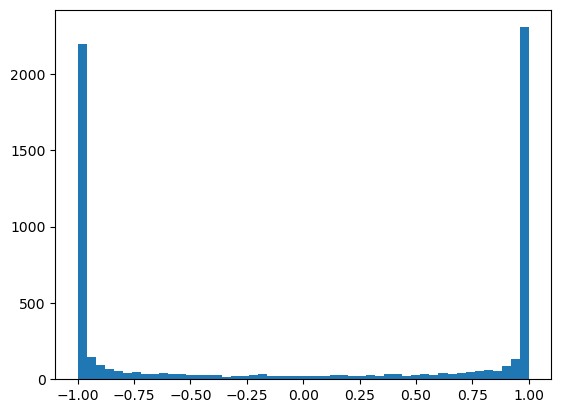

In [ ]:
plot.hist(h.view(-1).tolist(), 50);

As we can see most values are -1 and 1 

In [ ]:
def compute_pre_activation(parameters, X):
    C, W1, b1, W2, b2 = parameters
    emb = C[X]
    return emb.view(-1, W1.shape[0]) @ W1 + b1

In [ ]:
h_pre_act = compute_pre_activation(params4, batch_x)

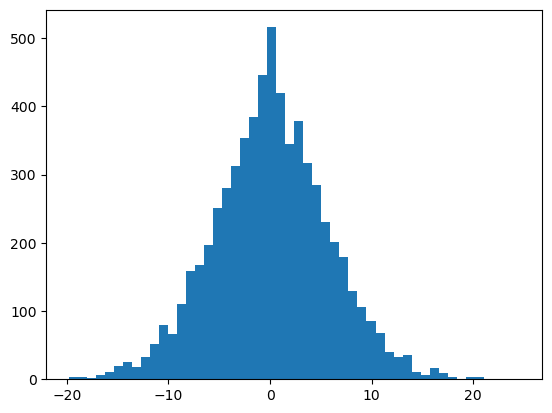

In [ ]:
plot.hist(h_pre_act.view(-1).tolist(), 50);

<matplotlib.image.AxesImage>

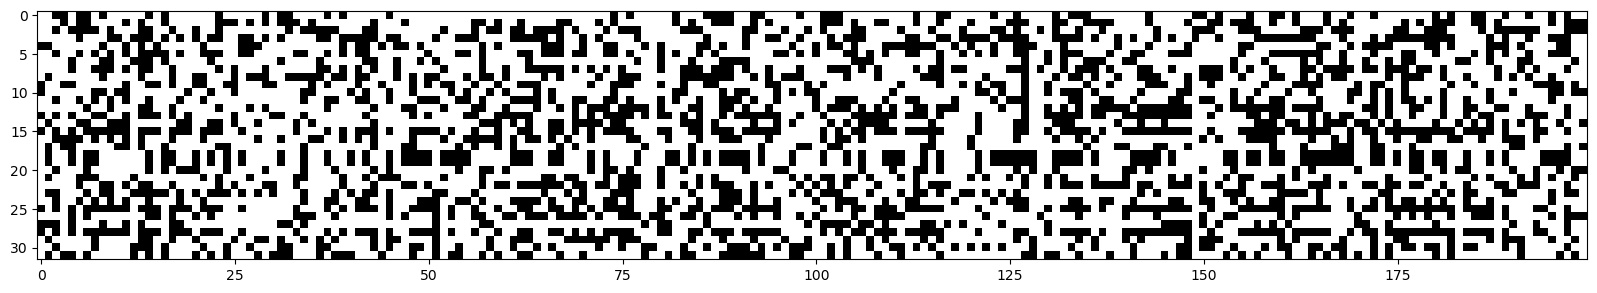

In [ ]:
plot.figure(figsize=(20, 10))
plot.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The `white` portion are the ones satisfying `h.abs() > 0.99` and `black` are the ones which are not satisfying the same

As we can see there are lots of whites, and the activations are lying mostly in the region of squashed

The gradient of tanh is `(1 - t**2) * out.grad` which will be 0 if tanh is +/-1, so there will be no gradients flowing through the network

If in the above image there is a single column of whites then that neuron will not learn anything for the batch of data

The `h_pre_act` is too off from zero therefore the activations are mostly -1 and 1. Lets change the parameters contributing to `h_pre_act`

In [ ]:
def initilialize_parameters_v3(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g) * 0.1
    b1 = torch.randn(hidden_neuron, generator=g) * 0.01
    W2 = torch.randn((hidden_neuron, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
    return [C, W1, b1, W2, b2]

In [ ]:
params5 = initilialize_parameters_v3(3, 10, 200)

In [ ]:
losses = train(params5, 1, Xtr, Ytr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 273.58it/s]

0 3.2925052642822266
0 3.2925052642822266


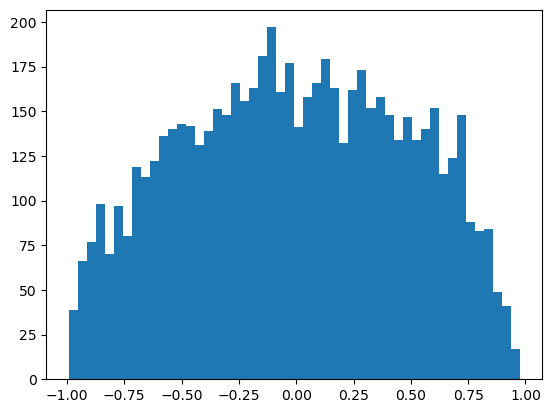

In [ ]:
h1 = compute_h(params5, batch_x)
plot.hist(h1.view(-1).tolist(), 50);

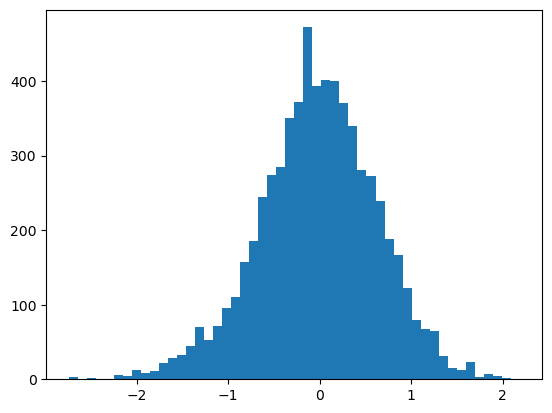

In [ ]:
h1_pre_act = compute_pre_activation(params5, batch_x)
plot.hist(h1_pre_act.view(-1).tolist(), 50);

<matplotlib.image.AxesImage>

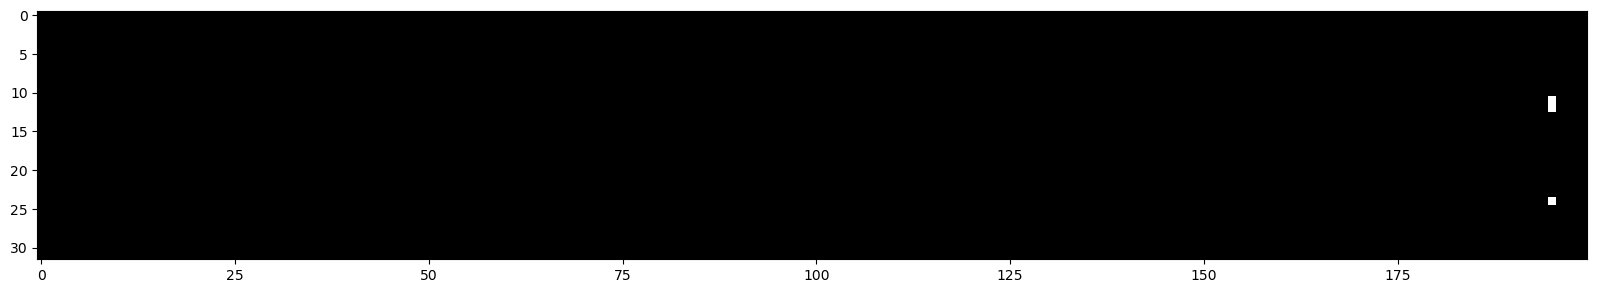

In [ ]:
plot.figure(figsize=(20, 10))
plot.imshow(h1.abs() > 0.99, cmap='gray', interpolation='nearest')

No neurons saturated over 0.99 in either direction

In [ ]:
def initilialize_parameters_v4(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g) * 0.2
    b1 = torch.randn(hidden_neuron, generator=g) * 0.01
    W2 = torch.randn((hidden_neuron, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
    return [C, W1, b1, W2, b2]

In [ ]:
params6 = initilialize_parameters_v4(3, 10, 200)

In [ ]:
losses = train(params6, 1, Xtr, Ytr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 387.46it/s]

0 3.315361976623535
0 3.315361976623535


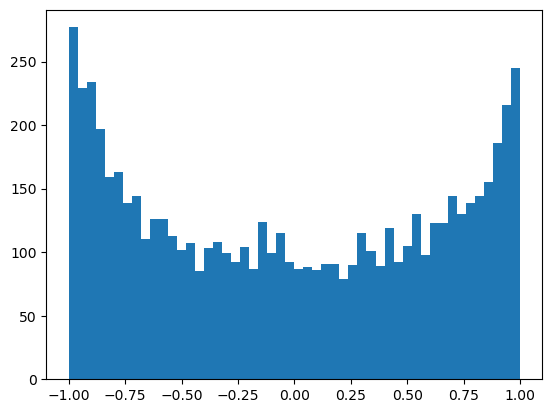

In [ ]:
h2 = compute_h(params6, batch_x)
plot.hist(h2.view(-1).tolist(), 50);

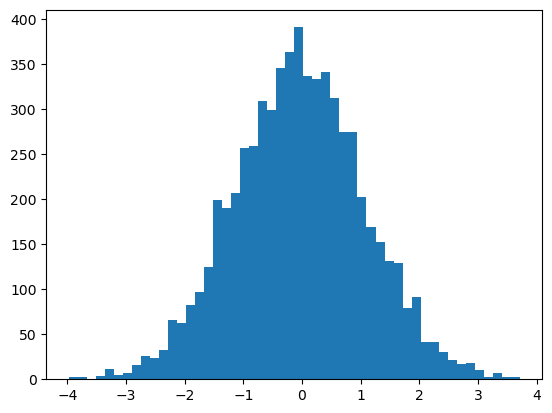

In [ ]:
h2_pre_act = compute_pre_activation(params6, batch_x)
plot.hist(h2_pre_act.view(-1).tolist(), 50);

<matplotlib.image.AxesImage>

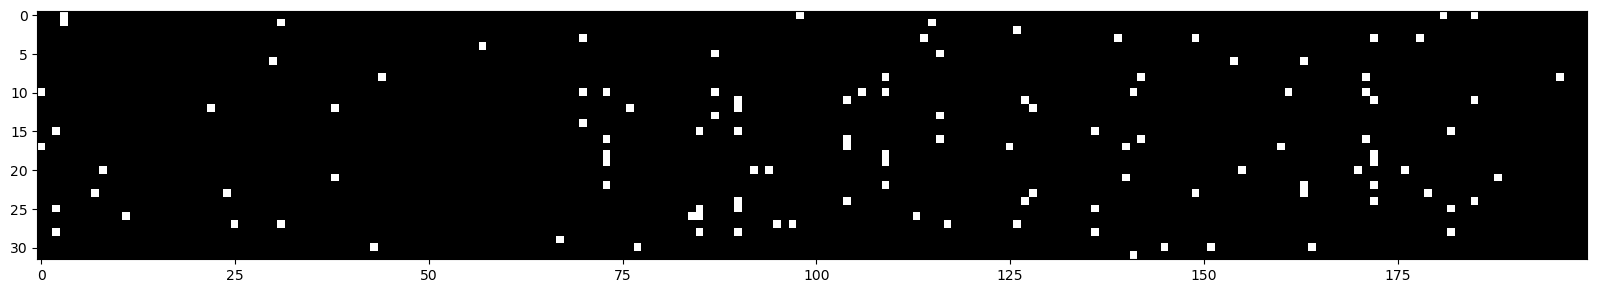

In [ ]:
plot.figure(figsize=(20, 10))
plot.imshow(h2.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
losses = train(params6, 200_000, Xtr, Ytr)

  0%|                                                                                                                                                                 | 114/200000 [00:00<05:52, 566.51it/s]

0 3.252462863922119


  5%|████████                                                                                                                                                       | 10086/200000 [00:18<05:32, 571.40it/s]

10000 2.2485759258270264


 10%|███████████████▉                                                                                                                                               | 20103/200000 [00:37<05:18, 564.13it/s]

20000 1.924424648284912


 15%|███████████████████████▉                                                                                                                                       | 30062/200000 [01:00<07:17, 388.41it/s]

30000 2.3567395210266113


 20%|███████████████████████████████▉                                                                                                                               | 40130/200000 [01:20<04:18, 618.81it/s]

40000 1.7223490476608276


 25%|███████████████████████████████████████▊                                                                                                                       | 50087/200000 [01:37<04:15, 587.11it/s]

50000 1.9401909112930298


 30%|███████████████████████████████████████████████▊                                                                                                               | 60082/200000 [01:54<04:00, 582.39it/s]

60000 2.2472681999206543


 35%|███████████████████████████████████████████████████████▋                                                                                                       | 70069/200000 [02:14<05:20, 405.03it/s]

70000 2.110548973083496


 40%|███████████████████████████████████████████████████████████████▋                                                                                               | 80094/200000 [02:38<03:43, 535.66it/s]

80000 1.9843206405639648


 45%|███████████████████████████████████████████████████████████████████████▌                                                                                       | 90067/200000 [03:00<03:50, 477.81it/s]

90000 2.498479127883911


 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 100049/200000 [03:26<03:11, 520.97it/s]

100000 2.0100741386413574


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 110095/200000 [03:54<03:16, 457.70it/s]

110000 1.9128767251968384


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 120021/200000 [04:21<02:43, 487.95it/s]

120000 2.1294615268707275


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 130064/200000 [04:40<02:11, 531.51it/s]

130000 1.7961547374725342


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 140109/200000 [05:01<01:48, 549.81it/s]

140000 1.6151217222213745


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 150027/200000 [05:22<01:33, 531.64it/s]

150000 1.905795693397522


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 160100/200000 [05:45<01:09, 573.43it/s]

160000 2.0080981254577637


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 170099/200000 [06:03<00:53, 562.53it/s]

170000 2.0118043422698975


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 180121/200000 [06:22<00:30, 652.22it/s]

180000 1.73159921169281


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 190125/200000 [06:38<00:14, 664.52it/s]

190000 2.196617841720581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [16:38:01<00:00,  3.34it/s]

199999 2.2335524559020996


In [ ]:
loss_split(params6, 'train'), loss_split(params6, 'valid') 

(tensor(2.0385, grad_fn=<NllLossBackward0>),
 tensor(2.1043, grad_fn=<NllLossBackward0>))

## Calculating the init scale: "Kaiming init"

tensor(-0.0029) tensor(0.9987)
tensor(-0.0028) tensor(3.1829)


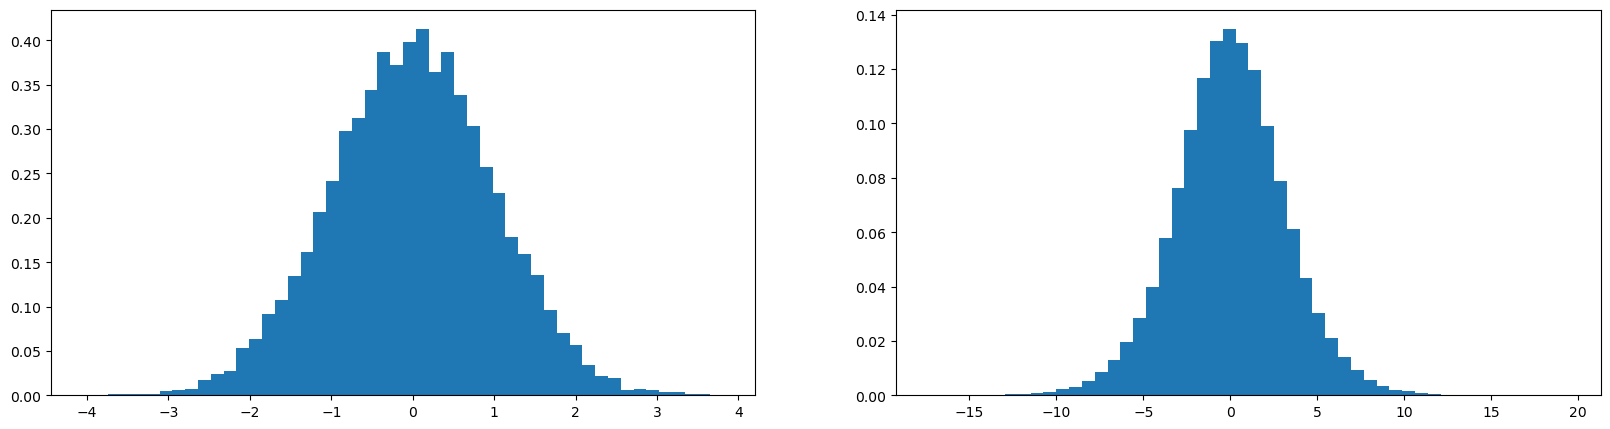

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plot.figure(figsize=(20, 5))
plot.subplot(121)
plot.hist(x.view(-1).tolist(), 50, density=True);
plot.subplot(122)
plot.hist(y.view(-1).tolist(), 50, density=True);

The `y` has more standard deviation compared to `x`

The guassian is expanding, we dont want that, we need similar activations during initialization

If we multiply `w` by a large number i.e. 5, then the standard deviation increases

tensor(-0.0073) tensor(0.9939)
tensor(0.0191) tensor(15.9527)


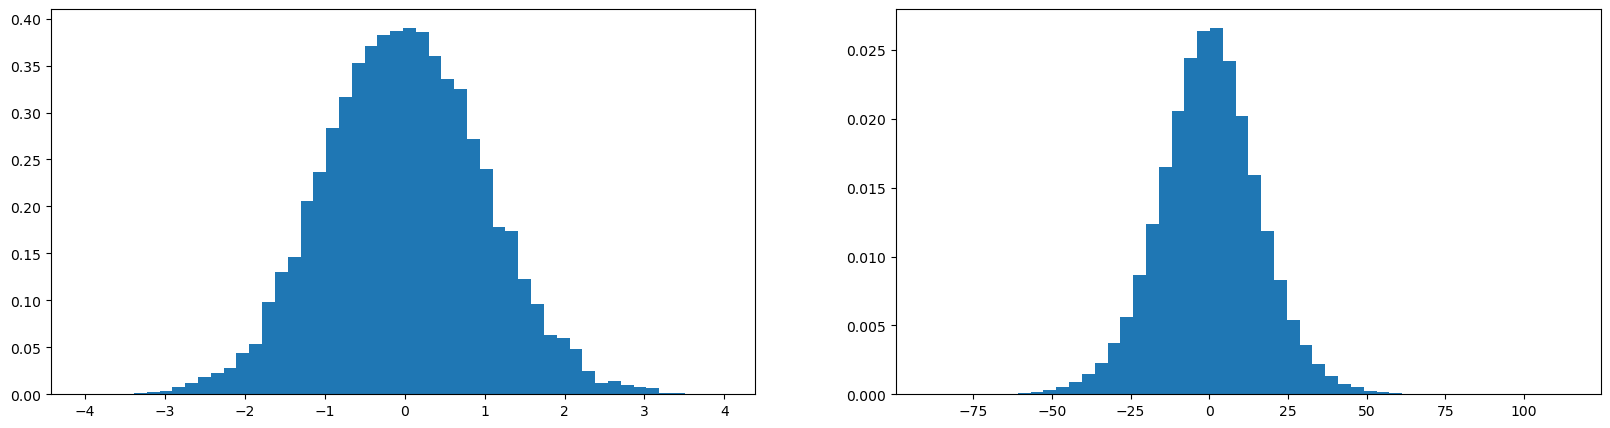

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plot.figure(figsize=(20, 5))
plot.subplot(121)
plot.hist(x.view(-1).tolist(), 50, density=True);
plot.subplot(122)
plot.hist(y.view(-1).tolist(), 50, density=True);

if we multiply `w` by a small number, then the standard deviation will be smaller

tensor(-0.0038) tensor(0.9879)
tensor(-0.0003) tensor(0.6244)


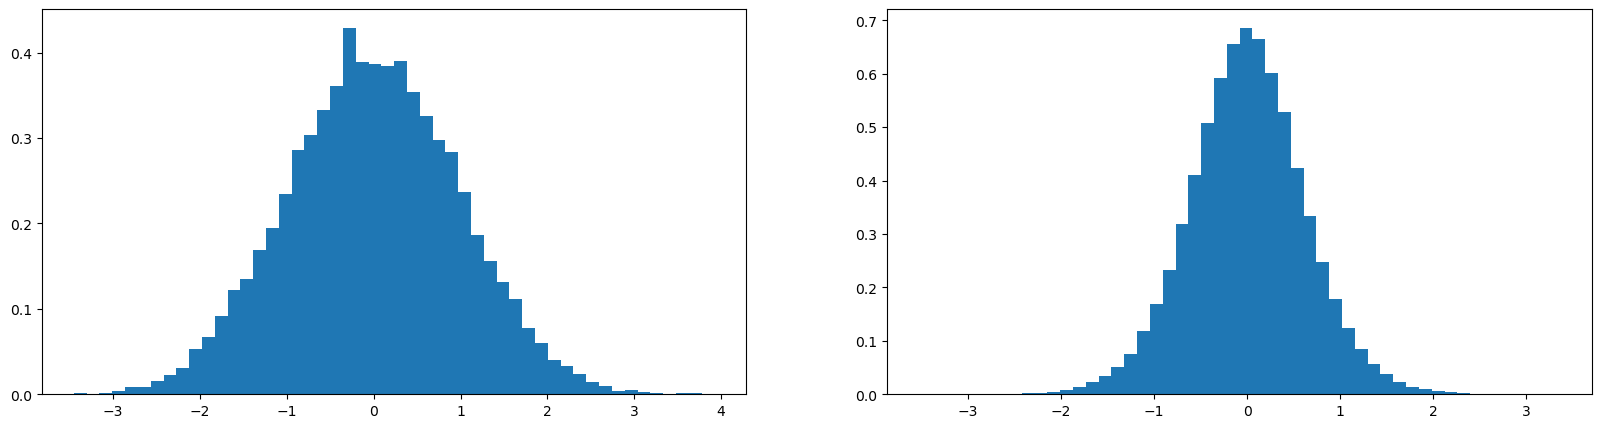

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plot.figure(figsize=(20, 5))
plot.subplot(121)
plot.hist(x.view(-1).tolist(), 50, density=True);
plot.subplot(122)
plot.hist(y.view(-1).tolist(), 50, density=True);

What number should we multiply `w` by to preserve the standard deviation as 1?

> We can multiply by (1/sqrt(fan_in))

tensor(0.0040) tensor(0.9988)
tensor(-0.0010) tensor(0.9846)


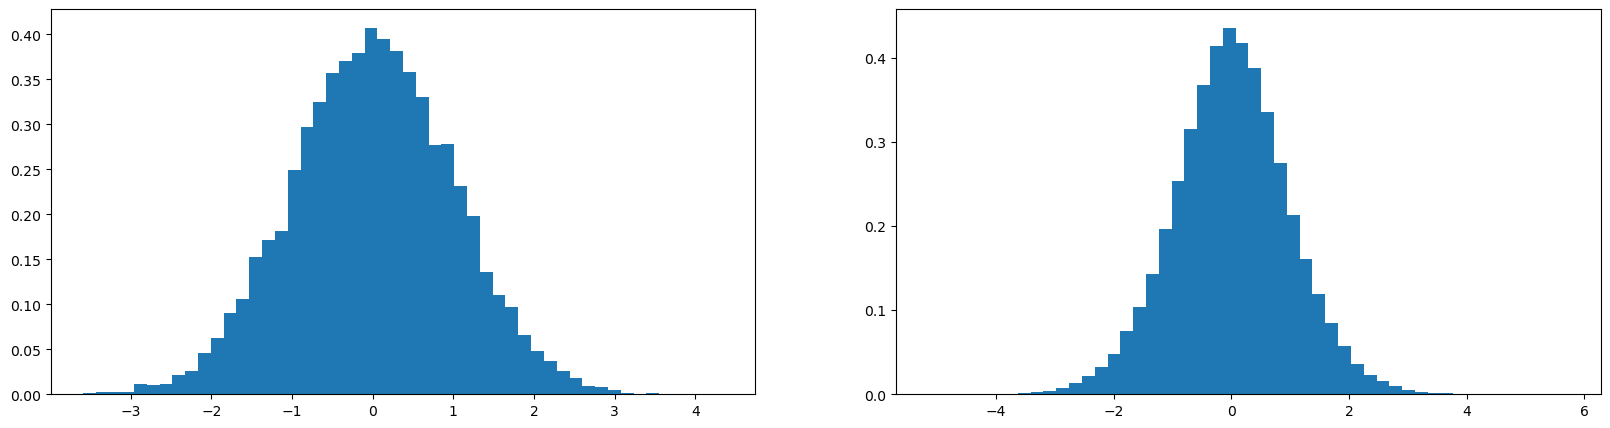

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 1/(math.sqrt(10))
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plot.figure(figsize=(20, 5))
plot.subplot(121)
plot.hist(x.view(-1).tolist(), 50, density=True);
plot.subplot(122)
plot.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
torch.randn(1000) 

tensor([-4.4491e-01,  8.1468e-01, -4.9041e-01,  8.5084e-01, -7.5546e-01,
        -1.2834e+00, -1.4080e-01, -1.5628e-01,  7.0759e-01,  5.4389e-01,
         1.0249e+00, -3.6809e-01,  1.5767e-01, -1.2903e-01, -9.6614e-01,
        -5.1882e-01, -1.0040e+00, -9.6146e-01, -4.9114e-02, -1.0125e+00,
         1.0659e+00,  1.3129e+00,  5.9042e-01, -1.3400e-01, -4.0615e-01,
         7.1402e-01,  8.5876e-01,  1.1057e+00, -1.7399e-01, -2.5380e-01,
        -1.9785e-01, -2.2213e+00,  3.8632e-02, -1.4455e+00,  1.4416e+00,
         4.6785e-02,  1.0486e+00,  1.7613e-02,  5.2755e-01, -1.3378e+00,
         7.3152e-01,  1.5148e+00, -9.0945e-01,  9.5265e-01,  1.7500e+00,
        -1.5277e+00, -5.6958e-02, -9.2872e-01, -5.7160e-01, -1.3054e+00,
         2.9642e-01, -9.0971e-01,  1.4852e-01,  4.8295e-01,  2.0170e-02,
        -1.5728e-01,  6.1446e-01, -7.2750e-01,  2.7242e-01, -5.0731e-01,
        -1.6935e+00, -1.1223e+00,  4.0411e-01,  7.8083e-01,  8.9397e-01,
         1.1677e+00, -1.6698e+00, -1.1389e-01, -1.3

In [ ]:
(torch.randn(1000) * 0.2).std()

tensor(0.2046)

In [ ]:
std_dev = (5/3) / (30 ** 0.5); std_dev

0.3042903097250923

In [ ]:
def initilialize_parameters_v5(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g) * ((5/3) / ((embedding_size * block_size) ** 0.5))
    b1 = torch.randn(hidden_neuron, generator=g) * 0.01
    W2 = torch.randn((hidden_neuron, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
    return [C, W1, b1, W2, b2]

In [ ]:
params7 = initilialize_parameters_v5(3, 10, 200)

In [ ]:
losses = train(params7, 200_000, Xtr, Ytr)

  0%|                                                                                                                                                                 | 132/200000 [00:00<05:09, 645.01it/s]

0 3.2795920372009277


  5%|████████                                                                                                                                                       | 10125/200000 [00:14<04:19, 733.07it/s]

10000 2.470160484313965


 10%|███████████████▊                                                                                                                                             | 20084/200000 [1:00:00<04:29, 668.33it/s]

20000 2.183413505554199


 15%|███████████████████████▋                                                                                                                                     | 30138/200000 [1:00:14<04:01, 702.35it/s]

30000 2.3951308727264404


 19%|██████████████████████████████▌                                                                                                                              | 38883/200000 [4:01:38<04:25, 605.88it/s]

40000 1.8953704833984375


 25%|███████████████████████████████████████▎                                                                                                                     | 50091/200000 [4:01:54<03:29, 715.16it/s]

50000 2.1281423568725586


 30%|███████████████████████████████████████████████▏                                                                                                             | 60084/200000 [4:02:09<03:31, 661.46it/s]

60000 2.08463454246521


 35%|███████████████████████████████████████████████████████                                                                                                      | 70071/200000 [4:02:24<03:19, 650.30it/s]

70000 1.564221739768982


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 80121/200000 [4:02:39<02:59, 667.73it/s]

80000 2.0972611904144287


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 90110/200000 [4:02:55<02:37, 695.86it/s]

90000 2.21366810798645


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 100130/200000 [4:03:10<02:26, 680.25it/s]

100000 2.302164077758789


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 110085/200000 [4:03:25<02:17, 655.44it/s]

110000 1.839044451713562


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 120089/200000 [4:03:40<02:04, 644.20it/s]

120000 1.8937313556671143


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 130067/200000 [4:03:55<01:46, 655.76it/s]

130000 2.7189743518829346


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 140063/200000 [4:04:10<01:29, 666.43it/s]

140000 2.1313252449035645


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 150093/200000 [4:04:25<01:19, 628.04it/s]

150000 1.9625704288482666


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 160115/200000 [4:04:40<00:53, 743.59it/s]

160000 1.89139723777771


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 170077/200000 [4:04:54<00:44, 677.63it/s]

170000 1.889981985092163


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 180117/200000 [4:05:08<00:26, 751.15it/s]

180000 1.9499194622039795


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 190117/200000 [4:05:23<00:14, 702.81it/s]

190000 1.9968667030334473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [4:05:37<00:00, 13.57it/s]

199999 1.9478144645690918


In [ ]:
loss_split(params7, 'train'), loss_split(params7, 'valid')

(tensor(2.0388, grad_fn=<NllLossBackward0>),
 tensor(2.1015, grad_fn=<NllLossBackward0>))

## Batch Normalization

### Normalization

In [ ]:
h_pre_act = compute_pre_activation(params7, batch_x)
h_pre_act.shape

torch.Size([32, 200])

In [ ]:
h_pre_act_mean = h_pre_act.mean(0, keepdim = True)
h_pre_act_mean.shape

torch.Size([1, 200])

In [ ]:
h_pre_act_std = h_pre_act.std(0, keepdim = True)
h_pre_act_std.shape

torch.Size([1, 200])

In [ ]:
h_pre_act_norm = (h_pre_act - h_pre_act_mean)/h_pre_act_std
h_pre_act_norm.shape

torch.Size([32, 200])

### Define new training

In [ ]:
def initilialize_parameters_v6(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g) * ((5/3) / ((embedding_size * block_size) ** 0.5))
    b1 = torch.randn(hidden_neuron, generator=g) * 0.01
    W2 = torch.randn((hidden_neuron, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
    
    bngain = torch.ones((1, hidden_neuron)) # for scale in batch normalization
    bnbias = torch.zeros((1, hidden_neuron)) # for shift in batch normalization
    
    return [C, W1, b1, W2, b2, bngain, bnbias]

In [ ]:
def compute_logits_v2(parameters, X):
    C, W1, b1, W2, b2, bngain, bnbias = parameters
    emb = C[X]
    embcat = emb.view(-1, W1.shape[0]) 
    h_pre_act = embcat @ W1 + b1
    h_pre_act_norm = (h_pre_act - h_pre_act.mean(0, keepdim = True)) / h_pre_act.std(0, keepdim = True)
    h_pre_act_scale_shift = bngain * h_pre_act_norm + bnbias
    h = torch.tanh(h_pre_act_scale_shift)
    logits = h @ W2 + b2
    return logits

In [ ]:
def train_v2(parameters,
          epochs,
          X, 
          Y, 
          bs=32, 
          lambdas = [0, 0, 0],
          enable_print=True,
          print_at_every_nth_epoch=10000
         ):
    
    if not parameters:
        raise Exception("No initial parameters passed")
    
    for p in parameters: p.requires_grad = True 
    
    losses = [] 
    
    for epoch in tqdm(range(epochs)):
        
        lr = 0.1 if epoch < 100_000 else 0.01
        
        ix = torch.randint(0, X.shape[0], (bs, ))
        batch_x, batch_y = X[ix], Y[ix]
        
        logits = compute_logits_v2(parameters, batch_x)
        
        loss = F.cross_entropy(logits, batch_y)
        regularization_loss = _regularization_loss(parameters, lambdas)
        loss += regularization_loss

        for p in parameters:
            p.grad= None
            
        loss.backward()


        for index, p in enumerate(parameters):
            if p.grad is None: print(index)
            p.data += - lr * p.grad

        if enable_print and epoch % print_at_every_nth_epoch == 0: print(epoch, loss.item())
            
        losses.append(loss.item())
        
    if enable_print:  print(epoch, loss.item())   
    return losses

In [ ]:
params8 = initilialize_parameters_v6(3, 10, 200)

In [ ]:
len(params8)

7

In [ ]:
losses = train_v2(params8, 200_000, Xtr, Ytr)

  0%|                                                                                                                                                                 | 104/200000 [00:00<06:19, 526.54it/s]

0 3.2974765300750732


  5%|████████                                                                                                                                                       | 10108/200000 [00:19<05:51, 539.73it/s]

10000 2.2444629669189453


 10%|███████████████▉                                                                                                                                               | 20082/200000 [00:37<05:26, 550.87it/s]

20000 2.0267117023468018


 15%|███████████████████████▊                                                                                                                                       | 29997/200000 [00:58<05:47, 489.55it/s]

30000 2.3122177124023438


 20%|███████████████████████████████▊                                                                                                                               | 40049/200000 [01:26<09:19, 285.73it/s]

40000 1.8772399425506592


 25%|███████████████████████████████████████▊                                                                                                                       | 50024/200000 [02:08<16:14, 153.85it/s]

50000 1.8241453170776367


 30%|███████████████████████████████████████████████▊                                                                                                               | 60073/200000 [02:38<04:36, 505.30it/s]

60000 2.2491812705993652


 35%|███████████████████████████████████████████████████████▋                                                                                                       | 70022/200000 [03:17<16:32, 130.95it/s]

70000 2.332838535308838


 40%|███████████████████████████████████████████████████████████████▋                                                                                               | 80090/200000 [03:41<04:08, 483.44it/s]

80000 2.2603352069854736


 45%|███████████████████████████████████████████████████████████████████████▌                                                                                       | 90063/200000 [04:00<03:17, 557.71it/s]

90000 2.521674394607544


 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 100101/200000 [04:20<03:10, 523.81it/s]

100000 2.1766295433044434


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 110071/200000 [04:39<03:39, 410.30it/s]

110000 2.0648574829101562


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 120058/200000 [05:16<02:55, 454.36it/s]

120000 1.9632437229156494


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 130062/200000 [05:37<02:17, 506.81it/s]

130000 2.6266632080078125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 140096/200000 [05:56<01:53, 527.01it/s]

140000 1.9747267961502075


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 150095/200000 [06:15<01:35, 525.17it/s]

150000 2.2220919132232666


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 160090/200000 [06:35<01:19, 502.85it/s]

160000 2.2269341945648193


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 170102/200000 [06:54<00:59, 501.19it/s]

170000 1.8781782388687134


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 180063/200000 [07:13<00:38, 511.77it/s]

180000 2.018829107284546


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 190075/200000 [07:32<00:18, 540.90it/s]

190000 1.694084644317627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [07:51<00:00, 424.08it/s]

199999 1.8435885906219482


In [ ]:
def evaluate_loss_v2(parameters, X, Y):
    logits = compute_logits_v2(parameters, X)
    return F.cross_entropy(logits, Y)

In [ ]:
def loss_split_v2(parameters, dataset='train'):
    dataset_choices = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte)
    }
    return evaluate_loss_v2(parameters, *dataset_choices[dataset])

In [ ]:
loss_split_v2(params8, 'train'), loss_split_v2(params8, 'valid')

(tensor(2.0683, grad_fn=<NllLossBackward0>),
 tensor(2.1130, grad_fn=<NllLossBackward0>))

### Consider the Training set mean and std deviation 

In [ ]:
def compute_batchnorm_mean_std(parameters):
    C, W1, b1, *rest = parameters
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)
    return bnmean, bnstd

In [ ]:
train_bnmean, train_bnstd = compute_batchnorm_mean_std(params8)

In [ ]:
def compute_logits_v3(parameters, X, bnmean=None, bnstd=None):
    C, W1, b1, W2, b2, bngain, bnbias = parameters
    emb = C[X]
    embcat = emb.view(-1, W1.shape[0]) 
    h_pre_act = embcat @ W1 + b1

    if  bnmean is None  and bnstd is None:
        bnmean = h_pre_act.mean(0, keepdim = True)
        bnstd = h_pre_act.std(0, keepdim = True)
        
    h_pre_act_norm = (h_pre_act - bnmean) / bnstd
    h_pre_act_scale_shift = bngain * h_pre_act_norm + bnbias
    h = torch.tanh(h_pre_act_scale_shift)
    logits = h @ W2 + b2
    return logits

In [ ]:
def evaluate_loss_v3(parameters, X, Y, bnmean, bnstd):
    logits = compute_logits_v3(parameters, X, bnmean, bnstd)
    return F.cross_entropy(logits, Y)

In [ ]:
def loss_split_v3(parameters, bnmean, bnstd, dataset='train'):
    dataset_choices = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte)
    }
    return evaluate_loss_v3(parameters, *dataset_choices[dataset], bnmean, bnstd)

In [ ]:
loss_split_v3(params8, train_bnmean, train_bnstd, 'train'), loss_split_v3(params8, train_bnmean, train_bnstd, 'valid')

(tensor(2.0683, grad_fn=<NllLossBackward0>),
 tensor(2.1131, grad_fn=<NllLossBackward0>))

### Compute running mean and std

In [ ]:
def initilialize_parameters_v7(block_size, embedding_size, hidden_neuron):
    C = torch.randn((27, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g) * ((5/3) / ((embedding_size * block_size) ** 0.5))
    b1 = torch.randn(hidden_neuron, generator=g) * 0.01
    W2 = torch.randn((hidden_neuron, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0
    
    bngain = torch.ones((1, hidden_neuron)) # for scale in batch normalization
    bnbias = torch.zeros((1, hidden_neuron)) # for shift in batch normalization
    
    bnmean_running = torch.zeros((1, hidden_neuron))
    bnstd_running = torch.ones((1, hidden_neuron))
    
    return [C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running]

In [ ]:
def compute_logits_v4(parameters, X, step='training'):
    C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running = parameters
    emb = C[X]
    embcat = emb.view(-1, W1.shape[0]) 
    h_pre_act = embcat @ W1 + b1

    if step == 'training':
        bnmeani = h_pre_act.mean(0, keepdim = True)
        bnstdi = h_pre_act.std(0, keepdim = True)

        with torch.no_grad():
            bnmean_running.data = 0.999 * bnmean_running.data + 0.001 * bnmeani
            bnstd_running.data = 0.999 * bnstd_running.data + 0.001 * bnstdi
    else:
        bnmeani = bnmean_running
        bnstdi = bnstd_running
        
    h_pre_act_norm = (h_pre_act - bnmeani) / bnstdi
    h_pre_act_scale_shift = bngain * h_pre_act_norm + bnbias
    h = torch.tanh(h_pre_act_scale_shift)
    logits = h @ W2 + b2
    return logits

In [ ]:
def train_v3(parameters,
          epochs,
          X, 
          Y, 
          bs=32, 
          lambdas = [0, 0, 0],
          enable_print=True,
          print_at_every_nth_epoch=10000
         ):
    
    if not parameters:
        raise Exception("No initial parameters passed")
    
    for p in parameters: p.requires_grad = True 
    
    losses = [] 
    
    for epoch in tqdm(range(epochs)):
        
        lr = 0.1 if epoch < 100_000 else 0.01
        
        ix = torch.randint(0, X.shape[0], (bs, ))
        batch_x, batch_y = X[ix], Y[ix]
        
        logits = compute_logits_v4(parameters, batch_x)
        
        loss = F.cross_entropy(logits, batch_y)
        regularization_loss = _regularization_loss(parameters, lambdas)
        loss += regularization_loss

        for p in parameters:
            p.grad= None
            
        loss.backward()


        for index, p in enumerate(parameters):
            if p.grad is not None: p.data += - lr * p.grad

        if enable_print and epoch % print_at_every_nth_epoch == 0: print(epoch, loss.item())
            
        losses.append(loss.item())
        
    if enable_print:  print(epoch, loss.item())   
    return losses

In [ ]:
params9 = initilialize_parameters_v7(3, 10, 200)

In [ ]:
losses = train_v3(params9, 200_000, Xtr, Ytr)

  0%|                                                                                                                                                                  | 53/200000 [00:00<11:28, 290.39it/s]

0 3.2910704612731934


  5%|████████                                                                                                                                                       | 10064/200000 [00:21<06:26, 491.17it/s]

10000 2.2731170654296875


 10%|███████████████▉                                                                                                                                               | 20069/200000 [00:44<06:25, 466.38it/s]

20000 2.676584482192993


 15%|███████████████████████▉                                                                                                                                       | 30094/200000 [01:05<05:47, 489.06it/s]

30000 2.425685405731201


 20%|███████████████████████████████▊                                                                                                                               | 40057/200000 [01:25<05:32, 481.69it/s]

40000 2.1894543170928955


 25%|███████████████████████████████████████▊                                                                                                                       | 50058/200000 [01:47<05:00, 499.70it/s]

50000 2.406543731689453


 30%|███████████████████████████████████████████████▊                                                                                                               | 60073/200000 [02:08<04:49, 483.97it/s]

60000 2.19313383102417


 35%|███████████████████████████████████████████████████████▋                                                                                                       | 70031/200000 [02:36<09:18, 232.65it/s]

70000 1.9194616079330444


 40%|███████████████████████████████████████████████████████████████▋                                                                                               | 80046/200000 [03:29<06:10, 323.66it/s]

80000 2.9036688804626465


 45%|████████████████████████████████████████████████████████████████████████                                                                                        | 90023/200000 [04:09<22:28, 81.54it/s]

90000 2.281238079071045


 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 100065/200000 [04:35<03:46, 440.83it/s]

100000 1.890221357345581


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 110070/200000 [05:05<03:09, 474.93it/s]

110000 2.034389019012451


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 120084/200000 [05:26<02:52, 462.69it/s]

120000 1.7974919080734253


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 130038/200000 [05:56<03:10, 367.74it/s]

130000 2.2577686309814453


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 140079/200000 [06:35<02:15, 443.66it/s]

140000 2.1341137886047363


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 150058/200000 [06:58<02:12, 375.75it/s]

150000 2.03934907913208


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 160053/200000 [07:30<01:22, 482.75it/s]

160000 2.2662088871002197


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 170064/200000 [08:07<01:10, 422.13it/s]

170000 2.285844564437866


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 180042/200000 [08:39<00:47, 422.86it/s]

180000 2.451364755630493


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 190066/200000 [09:03<00:22, 440.71it/s]

190000 2.512420654296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [09:44<00:00, 341.89it/s]


199999 2.0207467079162598


In [ ]:
train_bmean, train_bstd = compute_batchnorm_mean_std(params9)

In [ ]:
train_bmean.shape

torch.Size([1, 200])

In [ ]:
train_bstd.shape

torch.Size([1, 200])

In [ ]:
params9[-2]

tensor([[ 0.0375, -0.6331, -0.3791, -0.9008,  0.2962,  1.4619, -0.2891,  0.1883,
          0.3329,  0.2727, -0.9458, -0.6716, -0.5048, -0.6620,  0.2342,  1.1776,
          0.5657,  1.9836, -0.2188, -0.1207, -1.8573,  0.3398,  0.3636,  2.3903,
          0.4538,  0.0833, -1.0701, -0.7340, -0.3513,  1.9030, -0.7348, -0.4769,
         -2.3932, -0.3250,  0.3072,  0.4761,  1.0564, -0.9924, -0.5760,  1.1480,
         -1.0848,  1.0707,  1.4146, -1.5361, -1.7056, -1.0768,  0.5271, -0.1483,
         -0.3467, -1.4341,  0.3082, -0.1178,  1.0577, -1.3717,  0.2063, -0.7474,
         -0.5008,  0.7797, -0.4381, -0.5850, -0.6317,  0.9563, -1.2107,  0.2256,
         -0.3417, -0.0634, -1.0470, -0.7367,  0.4666, -0.9433,  0.0427,  0.6610,
         -0.0472, -0.6191, -0.2211, -0.3358, -0.1517, -0.5254,  1.0690, -1.2109,
         -0.2712, -1.7430, -1.3447,  0.6727,  0.9114, -0.9647, -0.1962,  0.2689,
         -0.5687,  0.5511, -0.1002,  0.4604, -0.3753, -0.3717, -0.8587, -0.2480,
         -0.8048,  0.5067,  

In [ ]:
train_bmean

tensor([[ 0.0336, -0.6265, -0.3734, -0.9142,  0.3122,  1.4727, -0.2720,  0.2043,
          0.3280,  0.2649, -0.9420, -0.6603, -0.5234, -0.6541,  0.2307,  1.1702,
          0.5762,  1.9697, -0.2134, -0.1228, -1.8548,  0.3674,  0.3822,  2.3695,
          0.4678,  0.0884, -1.0760, -0.7574, -0.3623,  1.9024, -0.7362, -0.4469,
         -2.3866, -0.3177,  0.2965,  0.4548,  1.0385, -0.9807, -0.5685,  1.1614,
         -1.0926,  1.0664,  1.4133, -1.5146, -1.6854, -1.0843,  0.5003, -0.1437,
         -0.3558, -1.4272,  0.2930, -0.1223,  1.0598, -1.3414,  0.2255, -0.7481,
         -0.5164,  0.7950, -0.4377, -0.5765, -0.6527,  0.9657, -1.1949,  0.2556,
         -0.3367, -0.0697, -1.0539, -0.7473,  0.4742, -0.9174,  0.0496,  0.6626,
         -0.0252, -0.6193, -0.2340, -0.3298, -0.1581, -0.5270,  1.0956, -1.1991,
         -0.2696, -1.7306, -1.3725,  0.6711,  0.9122, -0.9572, -0.1943,  0.2736,
         -0.5639,  0.5646, -0.0927,  0.4803, -0.3902, -0.3292, -0.8637, -0.2507,
         -0.8104,  0.5088,  

In [ ]:
params9[-1]

tensor([[2.4632, 2.3683, 2.4826, 2.0530, 2.1001, 2.5936, 2.4268, 1.8161, 2.2527,
         2.2914, 2.0653, 1.7652, 2.0370, 2.3531, 2.3336, 2.2467, 2.3725, 2.4981,
         2.1250, 1.9589, 2.4479, 2.1229, 1.9701, 2.6517, 2.4070, 2.2383, 1.5956,
         1.9934, 2.2423, 2.3018, 2.1449, 1.9444, 2.1350, 2.3635, 2.1110, 2.2966,
         1.9588, 2.2902, 2.0242, 2.2285, 2.6163, 2.5771, 1.9682, 2.4096, 2.1897,
         1.9587, 2.5828, 2.2682, 1.5224, 2.2569, 2.0790, 2.0309, 2.7052, 2.0490,
         2.6919, 2.7425, 1.6170, 2.2639, 2.2183, 2.4126, 2.5572, 2.1070, 2.3111,
         2.1343, 2.4835, 1.9523, 2.4436, 2.1352, 2.6667, 2.5792, 2.4142, 2.3900,
         1.8665, 2.1212, 2.2905, 2.1226, 1.9209, 2.4108, 2.4251, 1.9492, 2.0006,
         2.7582, 2.5923, 2.1482, 1.9433, 1.8152, 2.2074, 1.9798, 2.1282, 2.5727,
         2.2498, 2.1983, 2.3262, 2.6791, 2.0241, 2.0521, 2.2381, 2.0871, 2.0417,
         2.5972, 2.0449, 2.4388, 1.9639, 2.2393, 2.1035, 2.1849, 1.9384, 2.3872,
         2.5280, 2.6528, 2.2

In [ ]:
train_bstd

tensor([[2.4732, 2.3784, 2.5213, 2.0699, 2.1313, 2.6214, 2.4610, 1.8370, 2.2874,
         2.3359, 2.0795, 1.7793, 2.0715, 2.3730, 2.3941, 2.2722, 2.4023, 2.5138,
         2.1447, 1.9971, 2.4711, 2.1447, 1.9872, 2.6469, 2.4311, 2.2664, 1.6039,
         2.0137, 2.2677, 2.3347, 2.1688, 1.9666, 2.1642, 2.4079, 2.1322, 2.3575,
         1.9967, 2.3048, 2.0512, 2.2445, 2.6568, 2.6134, 1.9959, 2.4373, 2.2055,
         1.9620, 2.6040, 2.3006, 1.5517, 2.2881, 2.1018, 2.0604, 2.7347, 2.0694,
         2.7125, 2.7579, 1.6329, 2.3031, 2.2478, 2.4416, 2.5732, 2.1449, 2.3496,
         2.1591, 2.5255, 1.9768, 2.4779, 2.1505, 2.6936, 2.5978, 2.4561, 2.3916,
         1.8887, 2.1492, 2.3122, 2.1676, 1.9488, 2.4345, 2.4486, 1.9695, 2.0231,
         2.7833, 2.6296, 2.1697, 1.9649, 1.8332, 2.2276, 1.9933, 2.1393, 2.5949,
         2.2839, 2.2298, 2.3553, 2.7204, 2.0429, 2.0738, 2.2546, 2.1089, 2.0694,
         2.6374, 2.0650, 2.4688, 1.9873, 2.2620, 2.1333, 2.2223, 1.9737, 2.4104,
         2.5586, 2.6578, 2.3

above values are close

In [ ]:
def evaluate_loss_v4(parameters, X, Y, bnmean, bnstd):
    logits = compute_logits_v4(parameters, X, 'evaluation')
    return F.cross_entropy(logits, Y)

In [ ]:
def loss_split_v4(parameters, bnmean, bnstd, dataset='train'):
    dataset_choices = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte)
    }
    return evaluate_loss_v4(parameters, *dataset_choices[dataset], bnmean, bnstd)

In [ ]:
loss_split_v4(params9, params9[-2], params9[-1], 'train'), loss_split_v4(params9, train_bnmean, train_bnstd, 'valid')

(tensor(2.0704, grad_fn=<NllLossBackward0>),
 tensor(2.1112, grad_fn=<NllLossBackward0>))

## Pytorchifying the code

In [ ]:
g = torch.Generator().manual_seed(2147483647)

In [ ]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `monentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * x_hat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean  + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [ ]:
def train(max_steps, X, Y, 
            bs = 32, 
            vocab_size = 27, # the number of characters
            n_embd = 10, # the dimensionality of the character embedding vectors
            n_hidden = 100, # the number of neurons in the hidden layer of the MLP
            block_size = 3, 
            weight_scale = 5/3,
            network_type = 'non-linear',
            learning_rate = None
         ):

    C = torch.randn((vocab_size, n_embd), generator=g)
    
    if network_type == 'linear':
        layers = [
            Linear(n_embd * block_size, n_hidden),
            Linear(n_hidden, n_hidden),
            Linear(n_hidden, n_hidden), 
            Linear(n_hidden, n_hidden), 
            Linear(n_hidden, n_hidden), 
            Linear(n_hidden, vocab_size)
        ]
    elif network_type == 'non-linear':
        layers = [
            Linear(n_embd * block_size, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, vocab_size)
        ]
    else:
        layers = [
            Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
        ]
    
    with torch.no_grad():
        # last layer: make less confident
        if network_type != 'batchnorm':
            layers[-1].weight *= 0.1
        else:
            layers[-1].gamma *= 0.1
        # all other layers: apply gain
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= weight_scale
                
    
    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print('Total number of parameters are :', sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True 
        
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (bs, ), generator = g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)
        
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        
        for p in parameters:
            p.grad = None
        
        loss.backward()
        
        lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
        if learning_rate: lr = learning_rate
        
        
        for p in parameters:
            p.data += -lr * p.grad
        
        # track stats
        if i % 10_000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
        with torch.no_grad():
            ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    return layers, parameters, lossi, ud

In [ ]:
l, p, li, ud = train(1, Xtr, Ytr, network_type = 'non-linear')

Total number of parameters are : 46497
      0/      1: 3.3099


In [ ]:
def visualize_histograms(layers, instance_layer = Tanh, output_type='forward'):
    plot.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, instance_layer):
            if output_type == 'forward': t = layer.out
            else: t = layer.out.grad
            print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plot.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plot.legend(legends)
    plot.title('gradient distribution')

layer 1 (      Tanh): mean -0.023409, std 7.497526e-01
layer 3 (      Tanh): mean -0.002852, std 6.864228e-01
layer 5 (      Tanh): mean +0.001338, std 6.732427e-01
layer 7 (      Tanh): mean -0.006005, std 6.569249e-01
layer 9 (      Tanh): mean -0.020739, std 6.626034e-01


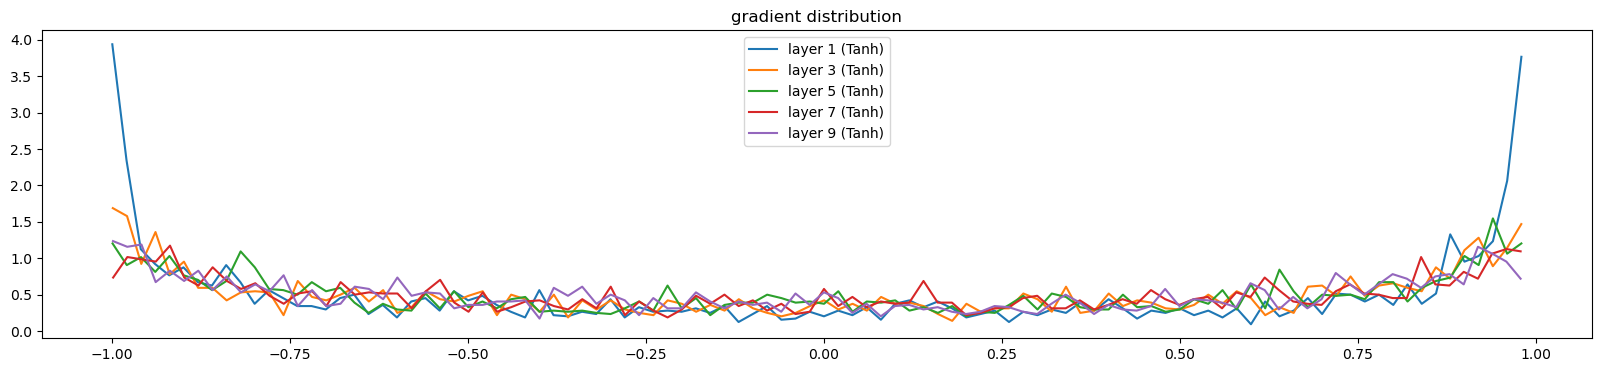

In [ ]:
visualize_histograms(l)

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


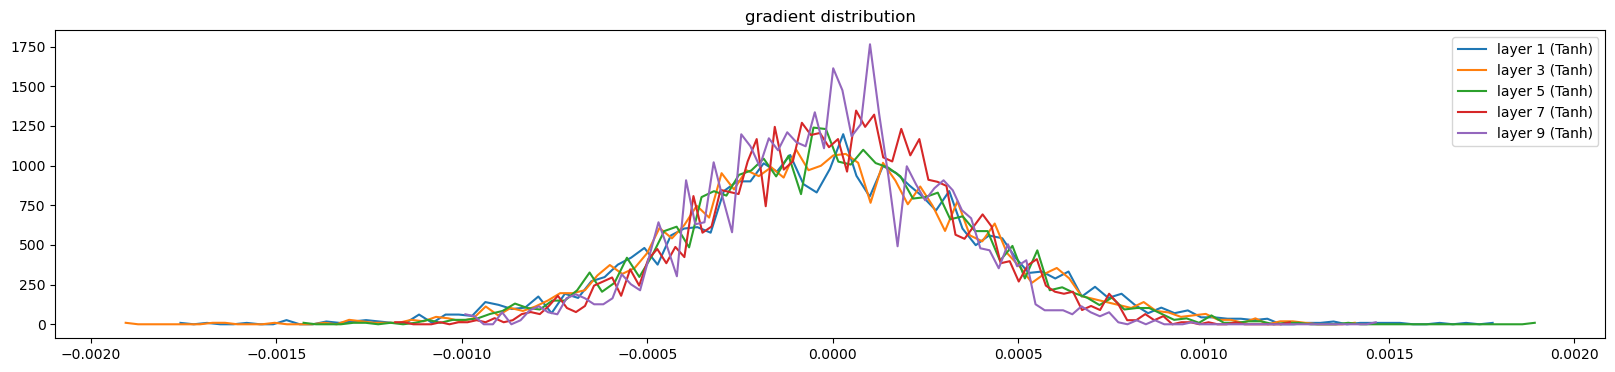

In [ ]:
visualize_histograms(l, output_type='backward')

### Only Non Linearities

In [ ]:
l, p, li, ud = train(1, Xtr, Ytr, network_type='linear')

Total number of parameters are : 46497
      0/      1: 3.9508


layer 0 (    Linear): mean -0.026808, std 1.717835e+00
layer 1 (    Linear): mean +0.066778, std 2.721437e+00
layer 2 (    Linear): mean +0.011798, std 4.644542e+00
layer 3 (    Linear): mean +0.402860, std 7.625082e+00
layer 4 (    Linear): mean +0.125483, std 1.243459e+01


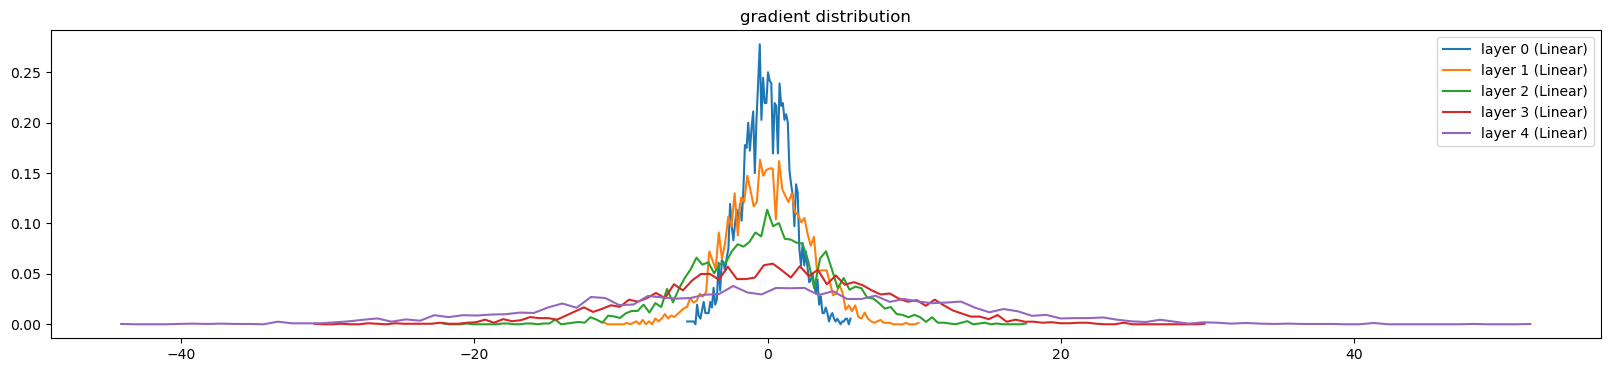

In [ ]:
visualize_histograms(l, instance_layer=Linear)

layer 0 (    Linear): mean -0.000040, std 2.520851e-03
layer 1 (    Linear): mean +0.000041, std 1.514516e-03
layer 2 (    Linear): mean +0.000030, std 9.373975e-04
layer 3 (    Linear): mean +0.000000, std 5.414668e-04
layer 4 (    Linear): mean +0.000006, std 3.237360e-04


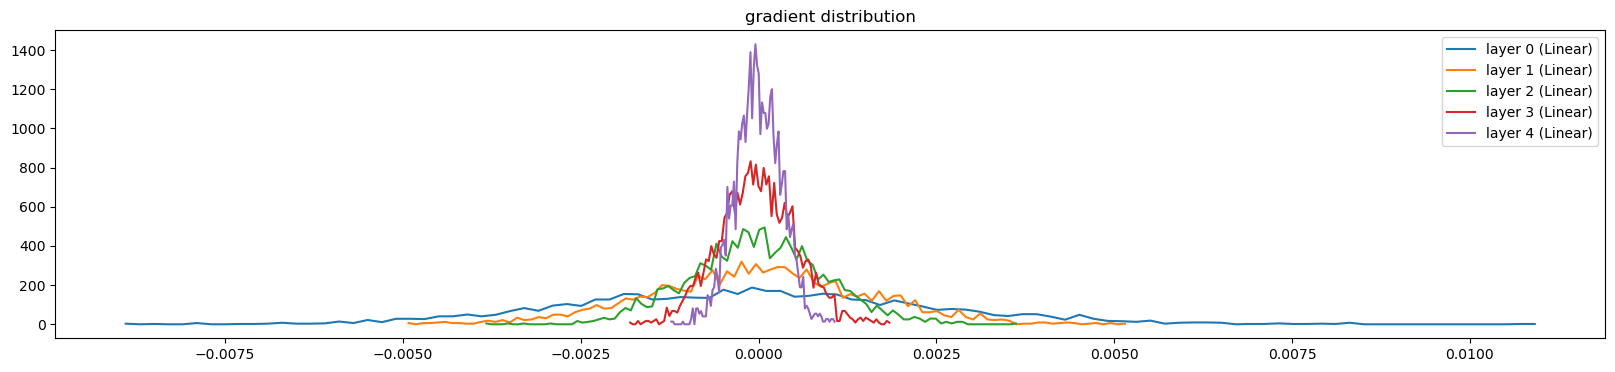

In [ ]:
visualize_histograms(l, instance_layer=Linear, output_type='backward')

In [ ]:
l, p, li, ud = train(1, Xtr, Ytr, weight_scale = 0.5, network_type='linear')

Total number of parameters are : 46497
      0/      1: 3.2955


layer 0 (    Linear): mean +0.005062, std 5.380081e-01
layer 1 (    Linear): mean +0.003729, std 2.749813e-01
layer 2 (    Linear): mean +0.004225, std 1.427801e-01
layer 3 (    Linear): mean +0.000118, std 7.137968e-02
layer 4 (    Linear): mean -0.000081, std 3.339273e-02


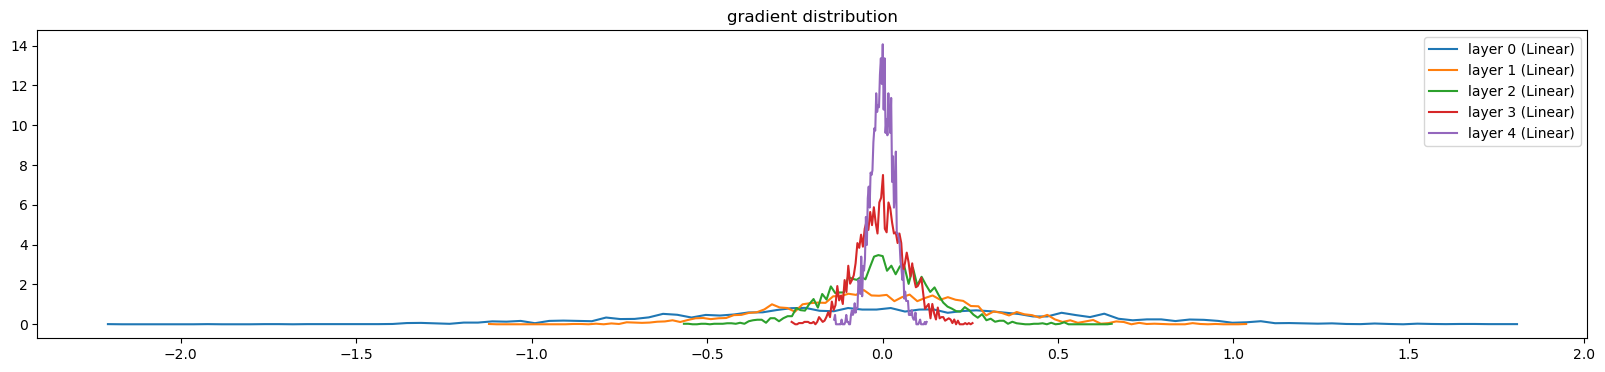

In [ ]:
visualize_histograms(l, instance_layer=Linear)

layer 0 (    Linear): mean -0.000001, std 2.208486e-05
layer 1 (    Linear): mean +0.000000, std 4.229027e-05
layer 2 (    Linear): mean +0.000002, std 8.004090e-05
layer 3 (    Linear): mean +0.000003, std 1.509417e-04
layer 4 (    Linear): mean +0.000007, std 3.050811e-04


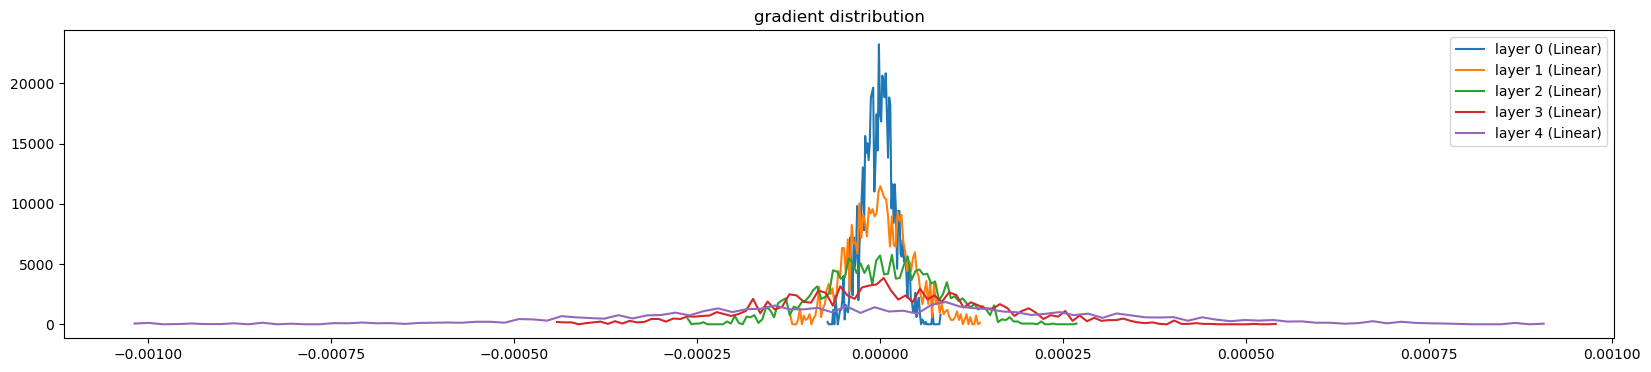

In [ ]:
visualize_histograms(l, instance_layer=Linear, output_type='backward')

In [ ]:
l, p, li, ud = train(1, Xtr, Ytr, weight_scale = 1, network_type='linear')

Total number of parameters are : 46497
      0/      1: 3.2962


layer 0 (    Linear): mean -0.033228, std 1.018080e+00
layer 1 (    Linear): mean +0.032009, std 9.739050e-01
layer 2 (    Linear): mean -0.021459, std 9.661991e-01
layer 3 (    Linear): mean -0.006396, std 9.748541e-01
layer 4 (    Linear): mean +0.008816, std 1.019902e+00


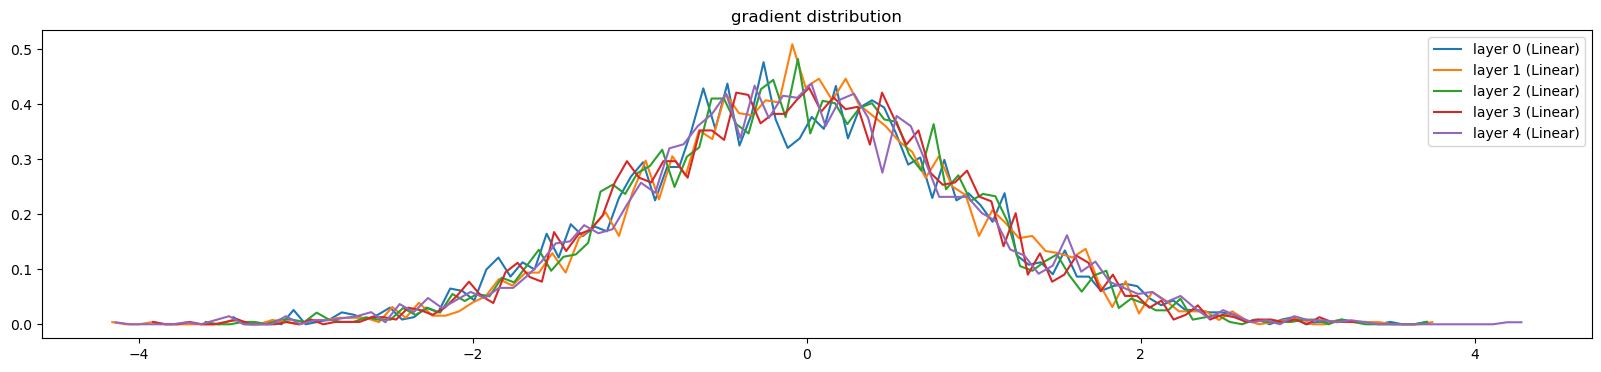

In [ ]:
visualize_histograms(l, instance_layer=Linear)

layer 0 (    Linear): mean +0.000011, std 3.135176e-04
layer 1 (    Linear): mean +0.000007, std 3.096962e-04
layer 2 (    Linear): mean -0.000003, std 3.211265e-04
layer 3 (    Linear): mean -0.000011, std 3.192310e-04
layer 4 (    Linear): mean -0.000010, std 3.158194e-04


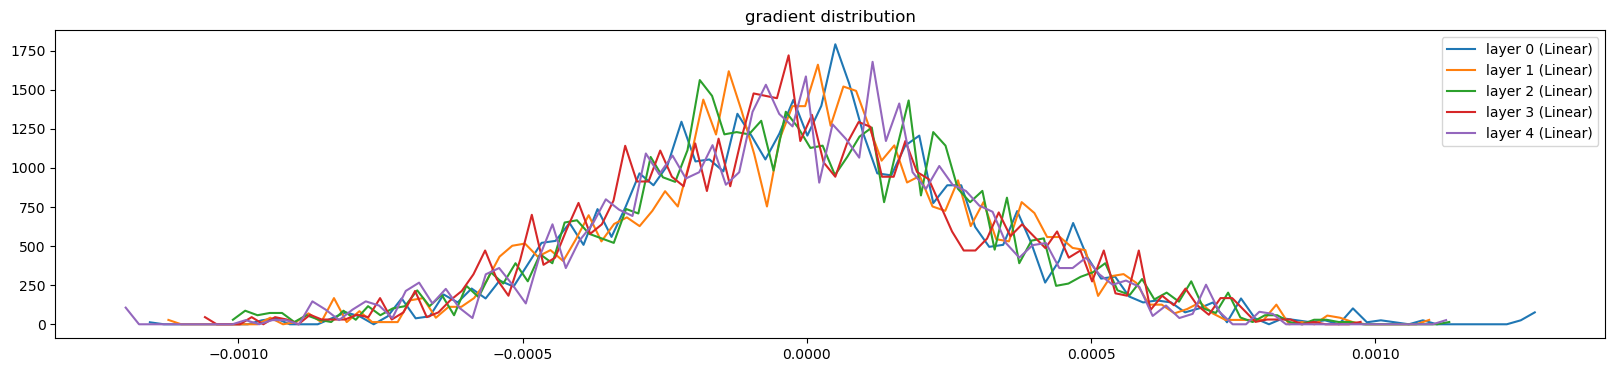

In [ ]:
visualize_histograms(l, instance_layer=Linear, output_type='backward')

#### grad: data ratio

In [ ]:
l, p, li, ud = train(1, Xtr, Ytr, weight_scale=1, network_type='linear')

Total number of parameters are : 46497
      0/      1: 3.2988


In [ ]:
def visualize_gain_data_ratio(parameters):
    plot.figure(figsize=(20, 4))
    legends = []
    for i, p in enumerate(parameters):
        t = p.grad
        if p.ndim==2: # excluding bias, gamma, beta
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' %(tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
            hy, hx = torch.histogram(t, density = True)
            plot.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i}{tuple(p.shape)}')
    plot.legend(legends)
    plot.title('Weights gradient distribution')

weight   (27, 10) | mean -0.000028 | std 9.268780e-04 | grad:data ratio 8.800050e-04
weight  (30, 100) | mean -0.000030 | std 1.736440e-03 | grad:data ratio 9.734222e-03
weight (100, 100) | mean -0.000002 | std 1.681667e-03 | grad:data ratio 1.686680e-02
weight (100, 100) | mean +0.000011 | std 1.695616e-03 | grad:data ratio 1.695003e-02
weight (100, 100) | mean -0.000042 | std 1.680904e-03 | grad:data ratio 1.670431e-02
weight (100, 100) | mean -0.000029 | std 1.830903e-03 | grad:data ratio 1.843546e-02
weight  (100, 27) | mean -0.000000 | std 3.505145e-02 | grad:data ratio 3.360777e+00


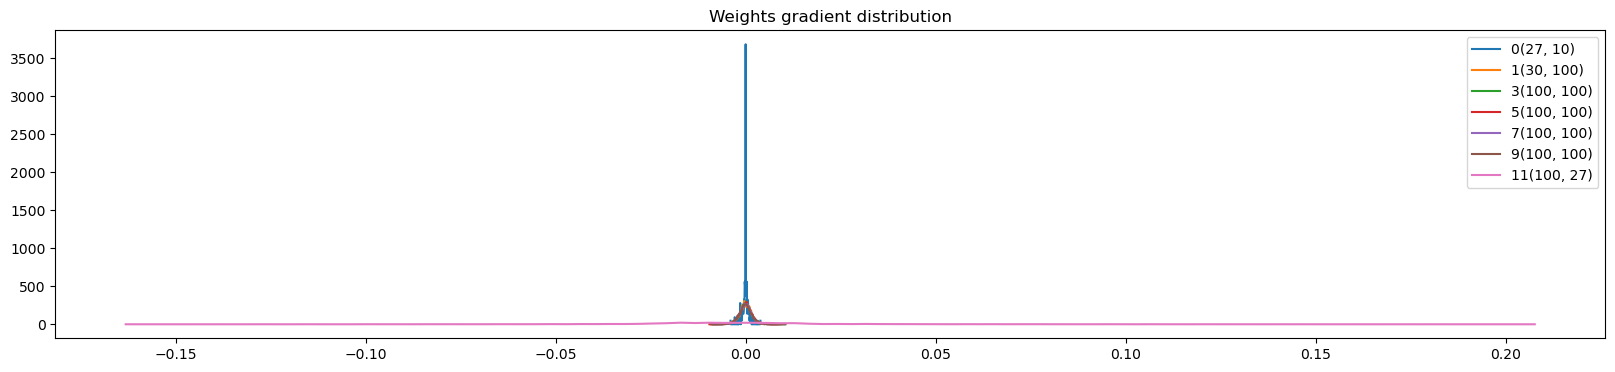

In [ ]:
visualize_gain_data_ratio(p)

In [ ]:
l, p, li, ud = train(1000, Xtr, Ytr, weight_scale=1, network_type='linear')

Total number of parameters are : 46497
      0/   1000: 3.2966


weight   (27, 10) | mean +0.001294 | std 1.157769e-02 | grad:data ratio 1.172457e-02
weight  (30, 100) | mean -0.000177 | std 1.309982e-02 | grad:data ratio 7.482659e-02
weight (100, 100) | mean +0.000006 | std 8.080219e-03 | grad:data ratio 8.206636e-02
weight (100, 100) | mean -0.000033 | std 6.700047e-03 | grad:data ratio 7.002961e-02
weight (100, 100) | mean +0.000095 | std 6.837256e-03 | grad:data ratio 7.082513e-02
weight (100, 100) | mean -0.000055 | std 6.807048e-03 | grad:data ratio 7.096651e-02
weight  (100, 27) | mean +0.000000 | std 2.501121e-02 | grad:data ratio 4.598068e-01


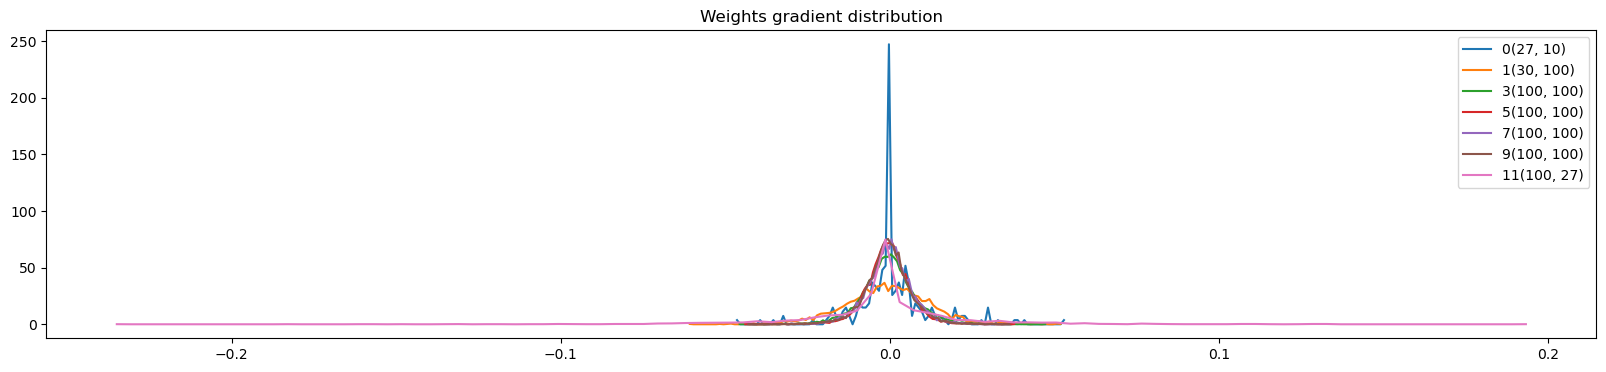

In [ ]:
visualize_gain_data_ratio(p)

#### data ratio over time

In [ ]:
def visualize_data_ratio_over_time(parameters, ud):
    plot.figure(figsize=(20, 4))
    legends = []
    for i, p in enumerate(parameters):
        if p.ndim == 2:
            plot.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plot.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~ 1e-3, indicate on plot
    plot.legend(legends);

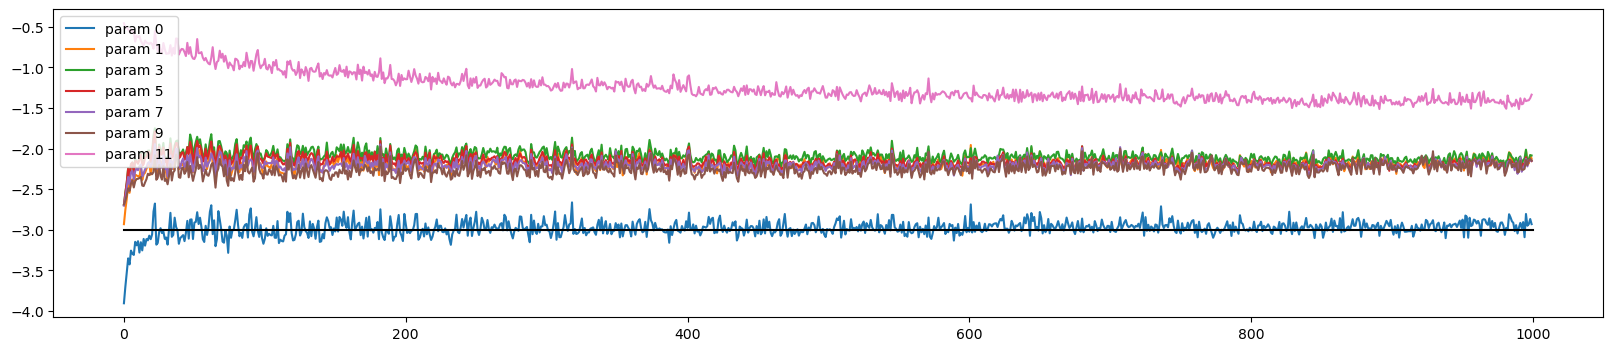

In [ ]:
visualize_data_ratio_over_time(p, ud)

In [ ]:
l, p, li, ud = train(1000, Xtr, Ytr, weight_scale=1, network_type='linear', learning_rate=0.001)

Total number of parameters are : 46497
      0/   1000: 3.3380


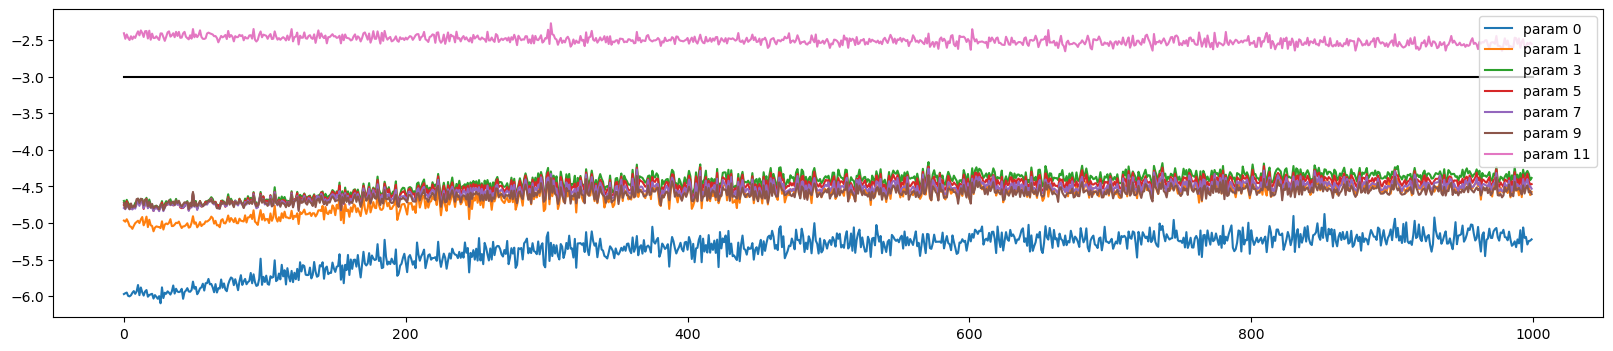

In [ ]:
visualize_data_ratio_over_time(p, ud)

In [ ]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
l, p, li, ud = train(1000, Xtr, Ytr)

Total number of parameters are : 46497
      0/   1000: 3.7327


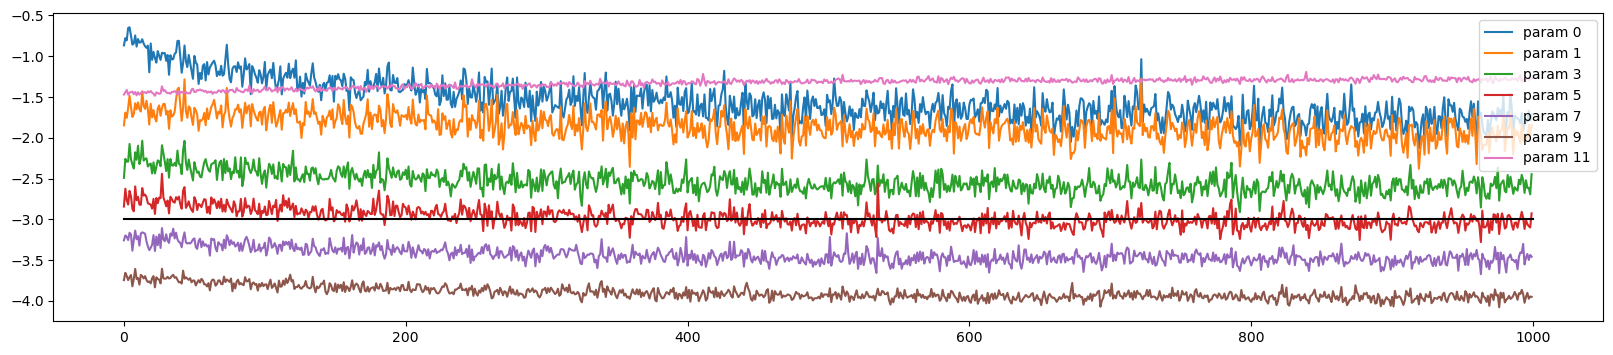

In [ ]:
visualize_data_ratio_over_time(p, ud)

In [ ]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
l, p, li, ud = train(1000, Xtr, Ytr, network_type = 'batchnorm')

Total number of parameters are : 47551
      0/   1000: 3.3050


layer 2 (      Tanh): mean -0.002824, std 6.360319e-01
layer 5 (      Tanh): mean -0.003577, std 6.418643e-01
layer 8 (      Tanh): mean -0.000634, std 6.393718e-01
layer 11 (      Tanh): mean +0.004614, std 6.429055e-01
layer 14 (      Tanh): mean -0.005592, std 6.441681e-01


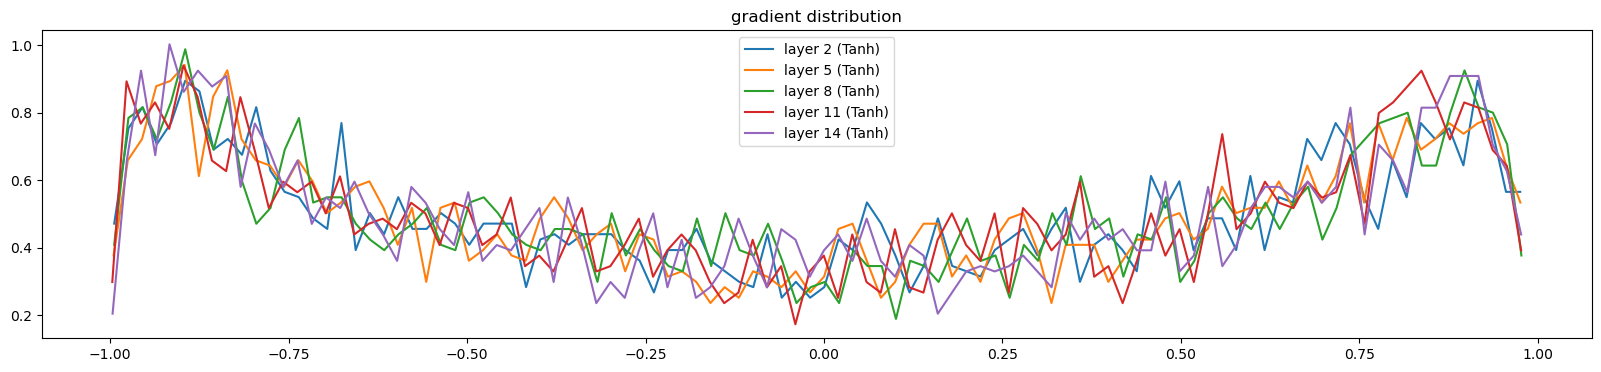

In [ ]:
visualize_histograms(l)

layer 2 (      Tanh): mean +0.000000, std 3.329200e-03
layer 5 (      Tanh): mean +0.000000, std 3.038263e-03
layer 8 (      Tanh): mean -0.000000, std 2.737059e-03
layer 11 (      Tanh): mean +0.000000, std 2.601666e-03
layer 14 (      Tanh): mean -0.000000, std 2.437597e-03


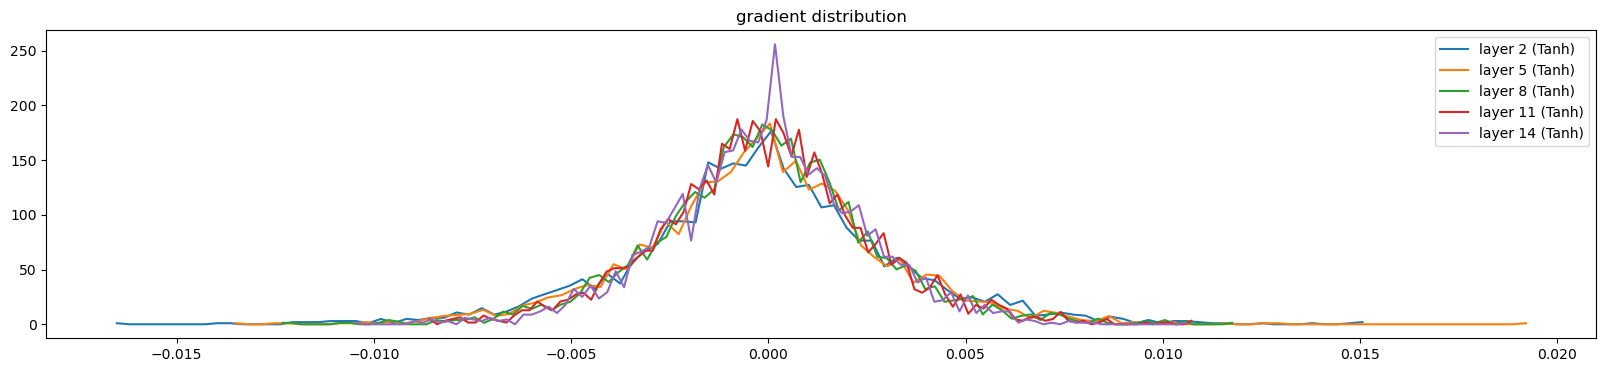

In [ ]:
visualize_histograms(l, output_type='backward')

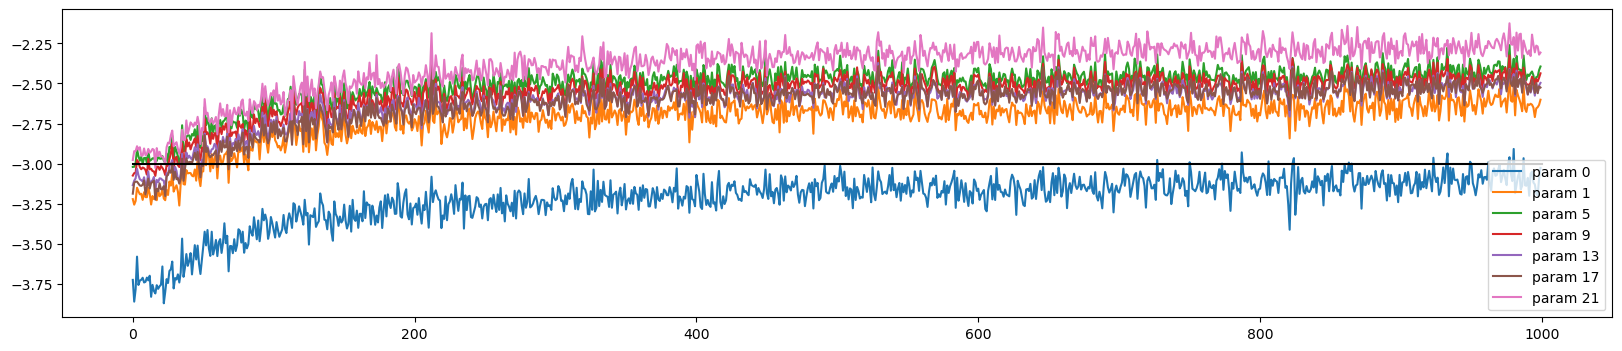

In [ ]:
visualize_data_ratio_over_time(p, ud)

In [ ]:
l, p, li, ud = train(1000, Xtr, Ytr, weight_scale=0.2, network_type = 'batchnorm')

Total number of parameters are : 47551
      0/   1000: 3.2990


layer 2 (      Tanh): mean -0.001280, std 6.382423e-01
layer 5 (      Tanh): mean +0.004930, std 6.569912e-01
layer 8 (      Tanh): mean -0.003945, std 6.697033e-01
layer 11 (      Tanh): mean -0.000414, std 6.793090e-01
layer 14 (      Tanh): mean -0.002082, std 6.810060e-01


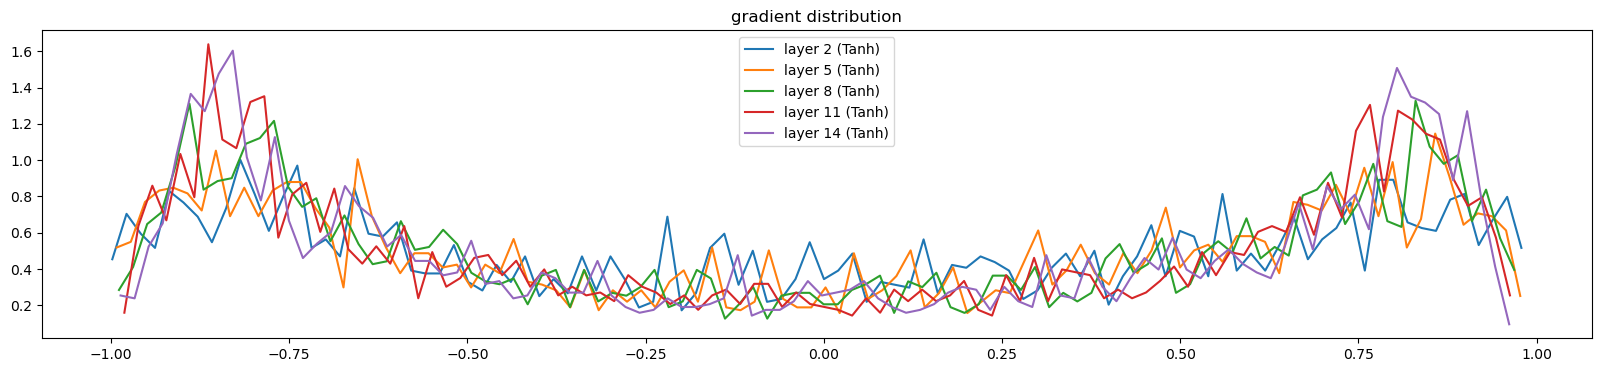

In [ ]:
visualize_histograms(l)

layer 2 (      Tanh): mean -0.000000, std 1.021346e-03
layer 5 (      Tanh): mean -0.000000, std 8.389445e-04
layer 8 (      Tanh): mean +0.000000, std 8.275748e-04
layer 11 (      Tanh): mean +0.000000, std 8.728803e-04
layer 14 (      Tanh): mean +0.000000, std 1.020851e-03


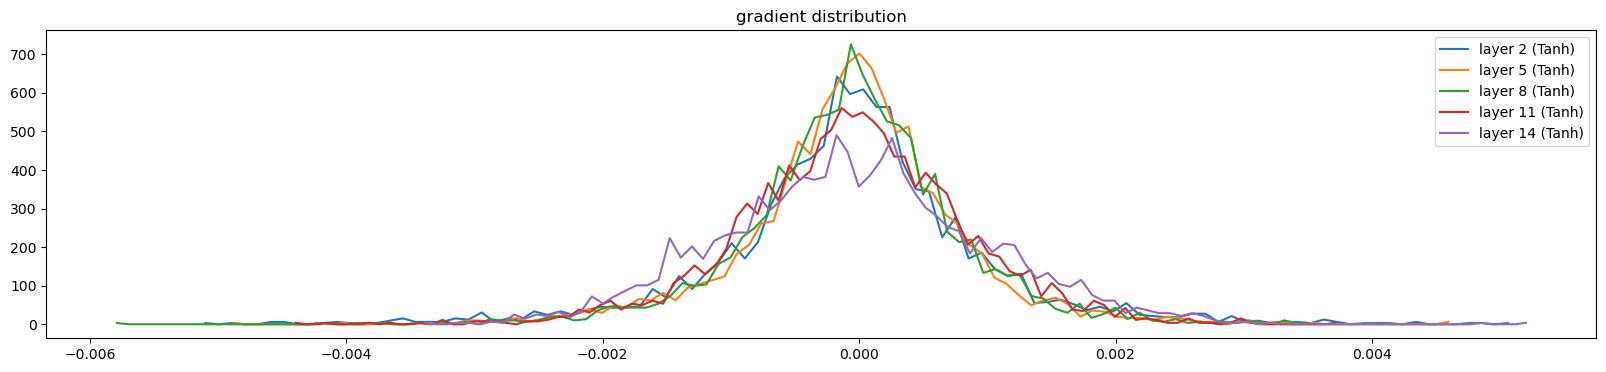

In [ ]:
visualize_histograms(l, output_type='backward')

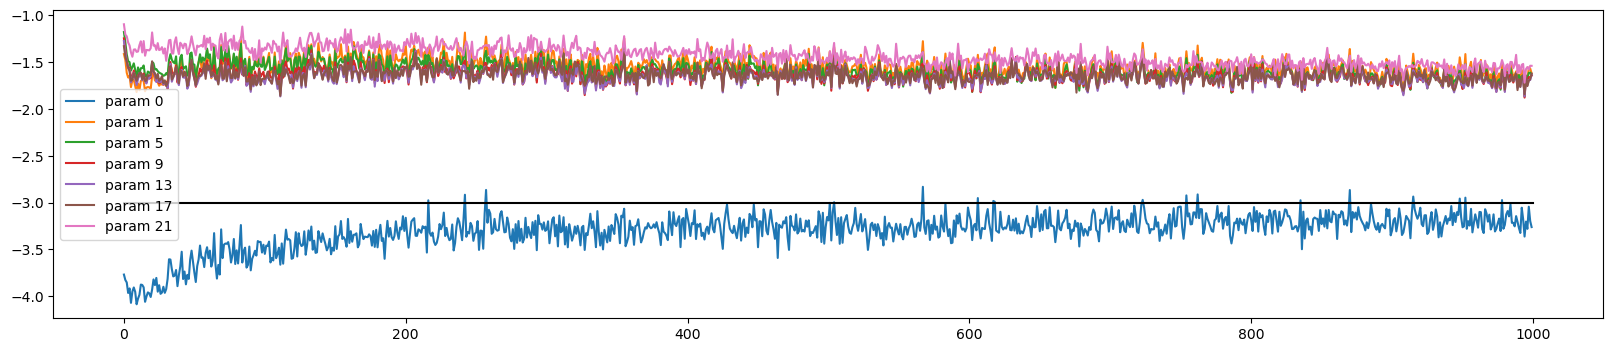

In [ ]:
visualize_data_ratio_over_time(p, ud)